# Performing Analysis on Tidy Text

## Acknowledgements
We would like to acknowledge the work of Julia Silge and David Robinson, whose materials were used under the terms of the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States License. Their contributions to open data science education, particularly the [Text Mining with R](https://www.tidytextmining.com), provided valuable resources for this project.

This notebook was created by Meara Cox using their code and examples as a foundation, with additional explanations and adaptations to support the goals of this project.

## Packages to Install

In [6]:
install.packages("tidytext")
install.packages("textdata")
install.packages("dplyr")
install.packages("stringr")
install.packages("janeaustenr")
install.packages("wordcloud")
install.packages("reshape2")
install.packages("igraph")
install.packages("ggraph")
install.packages("widyr")
install.packages("topicmodels")
install.packages("quanteda")
install.packages("rvest")
install.packages("tibble")
install.packages("purrr")





The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages are in
	/var/folders/2h/84wxzls579b1yv00g4jj02fh0000gn/T//RtmptdIsPl/downloaded_packages

The downloaded binary packages 

## Libraries to Import

In [ ]:

library(reshape2)
library(forcats)
library(gutenbergr)
library(igraph)
library(ggraph)
library(widyr)


Loading required package: RColorBrewer


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching package: 'igraph'


The following object is masked from 'package:tidyr':

    crossing


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




## Sentiment Analysis
In the previous chapter, we explored the tidy text format and how it helps analyze word frequency and compare documents. Now, we shift focus to opinion mining or sentiment analysis, where we assess the emotional tone of a text. Just as human readers infer emotions like positivity, negativity, surprise, or disgust from words, we can use text mining tools to programmatically analyze a text's emotional content. A common approach to sentiment analysis is to break the text into individual words, assign sentiment scores to those words, and sum them to understand the overall sentiment of the text. While this isn’t the only method for sentiment analysis, it is widely used and fits naturally within the tidy data framework and toolset.

### The `sentiments` Dataset 
As discussed earlier, there are several methods and dictionaries available for evaluating opinion or emotion in text. The **tidytext** package provides access to three commonly used general-purpose sentiment lexicons: **AFINN**, developed by [Finn Årup Nielsen](https://www2.imm.dtu.dk/pubdb/pubs/6010-full.html); **bing**, from [Bing Liu and collaborators](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html); and **nrc**, created by [Saif Mohammad and Peter Turney](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm). All three lexicons are based on unigrams, meaning they assign sentiment scores to individual words. The *nrc* lexicon categorizes words as positive, negative, or into specific emotions like joy, anger, sadness, and trust, using a simple "yes"/"no" system. The *bing* lexicon also applies a binary positive or negative label to each word, while the `AFINN` lexicon assigns numerical sentiment scores ranging from -5 (most negative) to 5 (most positive). These lexicons are distributed under different licenses, so it’s important to review the terms and ensure they align with your project requirements before use.


The [`get_sentiments()`](https://juliasilge.github.io/tidytext/reference/get_sentiments.html) function allows us to easily access specific sentiment lexicons along with their corresponding sentiment measures. By specifying the lexicon name (such as `"afinn"`, `"bing"`, or `"nrc"`), we can retrieve the appropriate set of words and their sentiment scores or categories, making it straightforward to incorporate sentiment analysis into a tidy text workflow.


In [140]:
library(tidytext)

print(get_sentiments("afinn"))

# A tibble: 2,477 x 2
   word       value
   <chr>      <dbl>
 1 abandon       -2
 2 abandoned     -2
 3 abandons      -2
 4 abducted      -2
 5 abduction     -2
 6 abductions    -2
 7 abhor         -3
 8 abhorred      -3
 9 abhorrent     -3
10 abhors        -3
# i 2,467 more rows


In [9]:
print(get_sentiments("bing"))

# A tibble: 6,786 x 2
   word        sentiment
   <chr>       <chr>    
 1 2-faces     negative 
 2 abnormal    negative 
 3 abolish     negative 
 4 abominable  negative 
 5 abominably  negative 
 6 abominate   negative 
 7 abomination negative 
 8 abort       negative 
 9 aborted     negative 
10 aborts      negative 
# i 6,776 more rows


In [10]:
print(get_sentiments("nrc"))

# A tibble: 13,872 x 2
   word        sentiment
   <chr>       <chr>    
 1 abacus      trust    
 2 abandon     fear     
 3 abandon     negative 
 4 abandon     sadness  
 5 abandoned   anger    
 6 abandoned   fear     
 7 abandoned   negative 
 8 abandoned   sadness  
 9 abandonment anger    
10 abandonment fear     
# i 13,862 more rows


The sentiment lexicons used in text mining were developed through either crowdsourcing platforms like Amazon Mechanical Turk or the manual effort of individual researchers, and they were validated using datasets such as crowdsourced opinions, movie or restaurant reviews, or Twitter posts. Because of this, applying these lexicons to texts that differ greatly in style or era—like 200-year-old narrative fiction—may produce less precise results, although shared vocabulary still allows meaningful sentiment analysis. In addition to these general-purpose lexicons, domain-specific options exist, such as those designed for financial texts. These dictionary-based methods work by summing the sentiment scores of individual words but have limitations, as they don't account for context, qualifiers, or negation (e.g., "not good"). For many types of narrative text where sarcasm or constant negation is minimal, this limitation is less significant, though later chapters explore strategies for handling negation. It's also important to choose an appropriate text chunk size for analysis—large text sections can have sentiment scores that cancel each other out, whereas sentence- or paragraph-level analysis often yields clearer results.


### Sentiment Analysis with Inner Join

When text data is in a tidy format, performing sentiment analysis becomes as simple as using an inner join. This highlights one of the key advantages of approaching text mining as a tidy data task—the tools and workflows remain consistent and intuitive. Just as removing stop words involves an `anti_join`, sentiment analysis works by applying an `inner_join` to combine the tokenized text with a sentiment lexicon, matching words in the text to their corresponding sentiment values. This tidy approach simplifies the process and integrates seamlessly with other tidyverse functions.

To find the most common joy-related words in *Emma* using the NRC lexicon, we first need to convert the novel's text into a tidy format with one word per row, using `unnest_tokens()`, just like we did earlier. To preserve important context, we can also create additional columns that track which line and chapter each word appears in. This is done using `group_by()` to organize the text by book and `mutate()` to assign line numbers and detect chapters, often using a regular expression. Once the text is structured this way, we can easily filter for words associated with joy in the NRC lexicon and analyze their frequency within the novel.

Notice that we named the output column from [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) as **word**, which is a practical and consistent choice. The sentiment lexicons and stop word datasets provided by **tidytext** also use **word** as the column name for individual tokens. By keeping this naming consistent, performing operations like `inner_join()` for sentiment analysis or `anti_join()` for removing stop words becomes straightforward and seamless, avoiding unnecessary renaming or data wrangling.

In [141]:
library(janeaustenr)
library(dplyr)
library(stringr)

tidy_books <- austen_books() %>%
  group_by(book) %>%
  mutate(
    linenumber = row_number(),
    chapter = cumsum(str_detect(text, 
                                regex("^chapter [\\divxlc]", 
                                      ignore_case = TRUE)))) %>%
  ungroup() %>%
  unnest_tokens(word, text)

Notice that we named the output column from [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) as `word`. This is a convenient choice, as both the sentiment lexicons and stop word lists use `word` as their column name, making joins and filtering operations much simpler.

With the text now in a tidy format—one word per row—we’re ready to run sentiment analysis. We’ll start by using the NRC lexicon and applying [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) to select only the words associated with joy. Then, we’ll filter the book text for words from *Emma* and use [`inner_join()`](https://dplyr.tidyverse.org/reference/mutate-joins.html) to connect it to the sentiment lexicon. To see the most common joy-related words in *Emma*, we can apply [`count()`](https://dplyr.tidyverse.org/reference/count.html) from **dplyr**.


In [12]:
nrc_joy <- get_sentiments("nrc") %>% 
  filter(sentiment == "joy")

tidy_books %>%
  filter(book == "Emma") %>%
  inner_join(nrc_joy) %>%
  count(word, sort = TRUE) %>%
  print()

Joining with `by = join_by(word)`


# A tibble: 301 x 2
   word          n
   <chr>     <int>
 1 good        359
 2 friend      166
 3 hope        143
 4 happy       125
 5 love        117
 6 deal         92
 7 found        92
 8 present      89
 9 kind         82
10 happiness    76
# i 291 more rows


We mostly see positive, uplifting words about hope, friendship, and love here. There are also some words that Austen may not have intended to sound joyful, like “found” or “present”; we’ll look at this issue more closely in Section 2.4.

We can also explore how sentiment shifts throughout each novel. This requires only a few lines of code, mostly using **dplyr** functions. First, we assign a sentiment score to each word by joining the Bing lexicon with our text using [`inner_join()`](https://dplyr.tidyverse.org/reference/mutate-joins.html).

Next, we count the number of positive and negative words within set sections of the text. To do this, we create an index to track our position in the narrative; this index uses integer division to group the text into sections of 80 lines each.

The `%/%` operator performs integer division (`x %/% y` is the same as `floor(x/y)`), allowing us to track which 80-line section we are analyzing for positive and negative sentiment.

If sections are too small, we might not have enough words to reliably estimate sentiment, while sections that are too large can blur the narrative structure. For these novels, 80-line sections work well, though the ideal size depends on factors like the length of the text and how the lines were structured originally. Finally, we use [`pivot_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html) to separate positive and negative sentiment into different columns and calculate the net sentiment by subtracting negative from positive.


In [143]:
library(tidyr)

jane_austen_sentiment <- tidy_books %>%
  inner_join(get_sentiments("bing")) %>%
  count(book, index = linenumber %/% 80, sentiment) %>%
  pivot_wider(names_from = sentiment, values_from = n, values_fill = 0) %>% 
  mutate(sentiment = positive - negative)

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 435443 of `x` matches multiple rows in `y`.
i Row 5051 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


Now that we’ve calculated sentiment scores for sections of each novel, we can visualize how sentiment changes over the course of the story. To do this, we plot the sentiment scores against the **index** on the x-axis, which represents the narrative timeline divided into sections of text.

This approach lets us clearly see how the emotional tone of each novel rises or falls, revealing points where the story shifts toward more positive or negative sentiment as the plot progresses. This provides a useful, high-level overview of the emotional structure of the narrative.


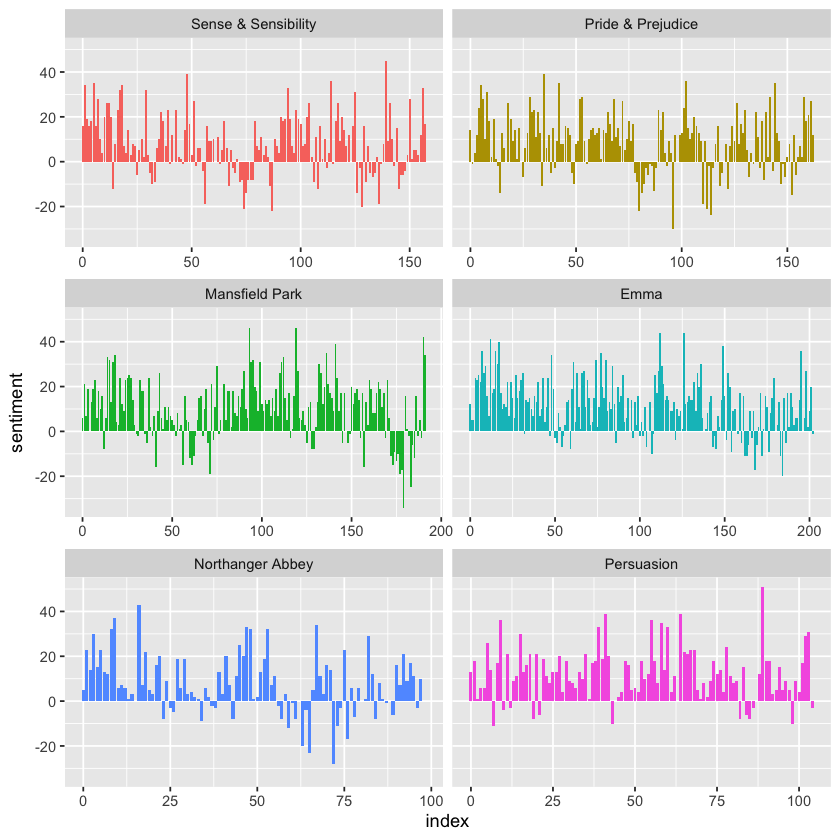

In [ ]:
library(ggplot2)

ggplot(jane_austen_sentiment, aes(index, sentiment, fill = book)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free_x")

### Comparing Sentiment Dictionaries

With multiple sentiment lexicons available, it's helpful to compare them to determine which best suits your analysis. To explore this, we can apply all three sentiment lexicons—**AFINN**, **bing**, and **nrc**—and examine how each captures sentiment changes across the narrative arc of *Pride and Prejudice*.

We start by using [`filter()`](https://dplyr.tidyverse.org/reference/filter.html) to isolate only the words from *Pride and Prejudice* so we can focus the analysis on that specific text. From there, we can apply each lexicon to compare how sentiment patterns emerge using different approaches.

In [15]:
pride_prejudice <- tidy_books %>% 
  filter(book == "Pride & Prejudice")

print(pride_prejudice)

# A tibble: 122,204 x 4
   book              linenumber chapter word     
   <fct>                  <int>   <int> <chr>    
 1 Pride & Prejudice          1       0 pride    
 2 Pride & Prejudice          1       0 and      
 3 Pride & Prejudice          1       0 prejudice
 4 Pride & Prejudice          3       0 by       
 5 Pride & Prejudice          3       0 jane     
 6 Pride & Prejudice          3       0 austen   
 7 Pride & Prejudice          7       1 chapter  
 8 Pride & Prejudice          7       1 1        
 9 Pride & Prejudice         10       1 it       
10 Pride & Prejudice         10       1 is       
# i 122,194 more rows


We can now use [`inner_join()`](https://dplyr.tidyverse.org/reference/mutate-joins.html) to apply the different sentiment lexicons and calculate sentiment scores throughout the novel. It’s important to remember that the **AFINN** lexicon assigns words a numeric score ranging from -5 (strongly negative) to 5 (strongly positive), while the **bing** and **nrc** lexicons categorize words simply as positive or negative.

Because of these differences, we use slightly different approaches when calculating sentiment for each lexicon. For all three, we divide the text into larger sections using integer division (`%/%`), grouping lines together to capture sentiment trends over meaningful chunks of the narrative. We then apply [`count()`](https://dplyr.tidyverse.org/reference/count.html), [`pivot_wider()`](https://tidyr.tidyverse.org/reference/pivot_wider.html), and [`mutate()`](https://dplyr.tidyverse.org/reference/mutate.html) to compute net sentiment in each section, allowing for a clear comparison of how sentiment evolves across the novel using each lexicon's unique scoring method.

In [16]:
afinn <- pride_prejudice %>% 
  inner_join(get_sentiments("afinn")) %>% 
  group_by(index = linenumber %/% 80) %>% 
  summarise(sentiment = sum(value)) %>% 
  mutate(method = "AFINN")

bing_and_nrc <- bind_rows(
  pride_prejudice %>% 
    inner_join(get_sentiments("bing")) %>%
    mutate(method = "Bing et al."),
  pride_prejudice %>% 
    inner_join(get_sentiments("nrc") %>% 
                 filter(sentiment %in% c("positive", 
                                         "negative"))
    ) %>%
    mutate(method = "NRC")) %>%
  count(method, index = linenumber %/% 80, sentiment) %>%
  pivot_wider(names_from = sentiment,
              values_from = n,
              values_fill = 0) %>% 
  mutate(sentiment = positive - negative)

Joining with `by = join_by(word)`


Joining with `by = join_by(word)`
Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("nrc") %>% filter(sentiment %in% :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 215 of `x` matches multiple rows in `y`.
i Row 5178 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


We now have calculated the net sentiment—positive minus negative—for each chunk of the novel text using all three sentiment lexicons: **AFINN**, **bing**, and **nrc**. The next step is to bind these results together into a single data frame so we can easily compare them side by side. Once combined, we can visualize the sentiment trends across the narrative using a plot. This allows us to directly observe how each lexicon captures emotional shifts in the story and highlights both the similarities and differences in their sentiment patterns.


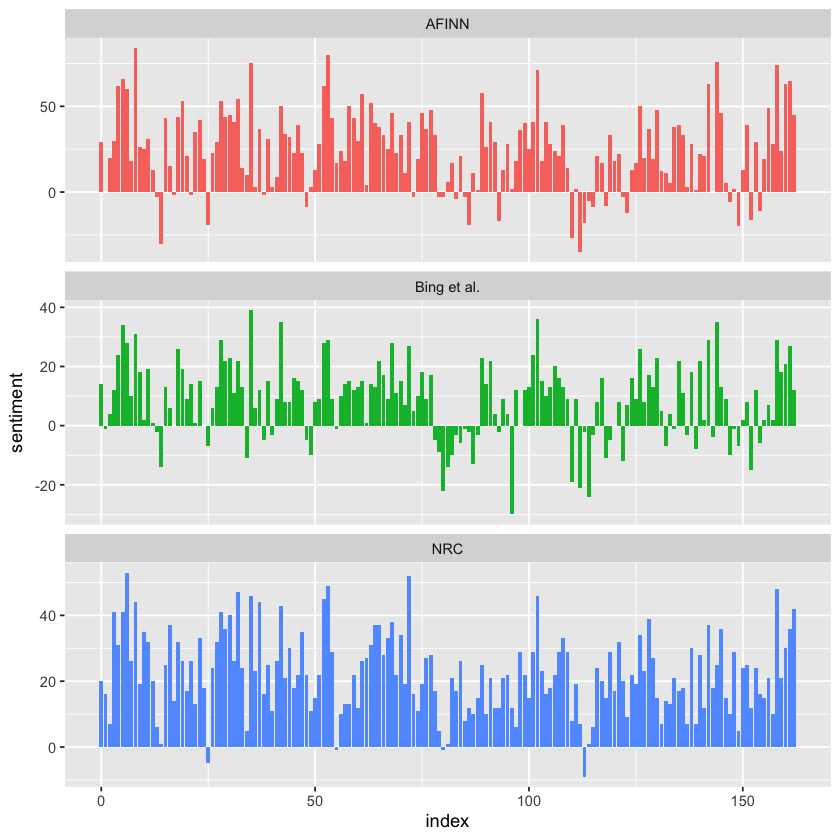

In [17]:
bind_rows(afinn, 
          bing_and_nrc) %>%
  ggplot(aes(index, sentiment, fill = method)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~method, ncol = 1, scales = "free_y")

The three sentiment lexicons produce different absolute results, but they reveal similar overall sentiment patterns across the novel. All three show comparable peaks and dips in sentiment at roughly the same points in the story, reflecting consistent emotional shifts. However, the **AFINN** lexicon tends to produce the largest absolute values, with higher positive and negative extremes. The **bing** lexicon shows smaller absolute values and often identifies longer stretches of consistently positive or negative text. Meanwhile, the **NRC** lexicon shifts the sentiment scores higher overall, labeling more of the text as positive but still capturing similar relative sentiment changes. These patterns are consistent across other novels as well: NRC sentiment tends to be higher, AFINN shows more variability, and Bing highlights longer contiguous blocks of sentiment, but all three lexicons generally agree on the broader narrative sentiment trends.

The NRC lexicon often produces higher overall sentiment scores compared to the Bing et al. lexicon because of differences in how the two are constructed. One key reason is that the NRC lexicon contains a larger proportion of positive words relative to negative words, which biases its overall sentiment scores upward. To better understand this, we can look at the actual counts of positive and negative words within each lexicon. By comparing how many words are labeled positive versus negative in both the NRC and Bing lexicons, we can see why the NRC results tend to skew more positive, even when both detect similar relative sentiment shifts across a text.

In [18]:
get_sentiments("nrc") %>% 
  filter(sentiment %in% c("positive", "negative")) %>% 
  count(sentiment) %>%
  print()

# A tibble: 2 x 2
  sentiment     n
  <chr>     <int>
1 negative   3316
2 positive   2308


In [19]:
get_sentiments("bing") %>% 
  count(sentiment) %>%
  print()

# A tibble: 2 x 2
  sentiment     n
  <chr>     <int>
1 negative   4781
2 positive   2005


Both the NRC and Bing lexicons actually contain more negative words than positive ones, but the Bing lexicon has a higher ratio of negative to positive words compared to NRC. This difference helps explain why the Bing lexicon tends to produce lower overall sentiment scores, while the NRC lexicon often skews more positive. Additionally, systematic differences in how well the lexicons’ negative words match the vocabulary of a particular author—like Jane Austen—can further influence the results. Despite these absolute differences, the lexicons generally show similar relative sentiment trajectories and changes in narrative slope across the text. This context is important to keep in mind when selecting a sentiment lexicon, as the choice can impact both the magnitude and interpretation of sentiment analysis results.

### Most Common Positive and Negative Words

One advantage of having a tidy data frame that includes both sentiment labels and individual words is that it allows us to directly analyze which words contribute to positive or negative sentiment. By using [`count()](https://dplyr.tidyverse.org/reference/count.html) with both the **word** and **sentiment** columns as arguments, we can quickly see how often each word appears in the text and how it contributes to either positive or negative sentiment. This approach provides a clear breakdown of which specific words are driving the sentiment patterns we observe, offering deeper insight into the language used in the text.

In [20]:
bing_word_counts <- tidy_books %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  ungroup()

print(bing_word_counts)

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 435443 of `x` matches multiple rows in `y`.
i Row 5051 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


# A tibble: 2,585 x 3
   word     sentiment     n
   <chr>    <chr>     <int>
 1 miss     negative   1855
 2 well     positive   1523
 3 good     positive   1380
 4 great    positive    981
 5 like     positive    725
 6 better   positive    639
 7 enough   positive    613
 8 happy    positive    534
 9 love     positive    495
10 pleasure positive    462
# i 2,575 more rows


This can also be visualized, and we can pipe the results directly into **ggplot2** thanks to the consistent use of tidy data tools.


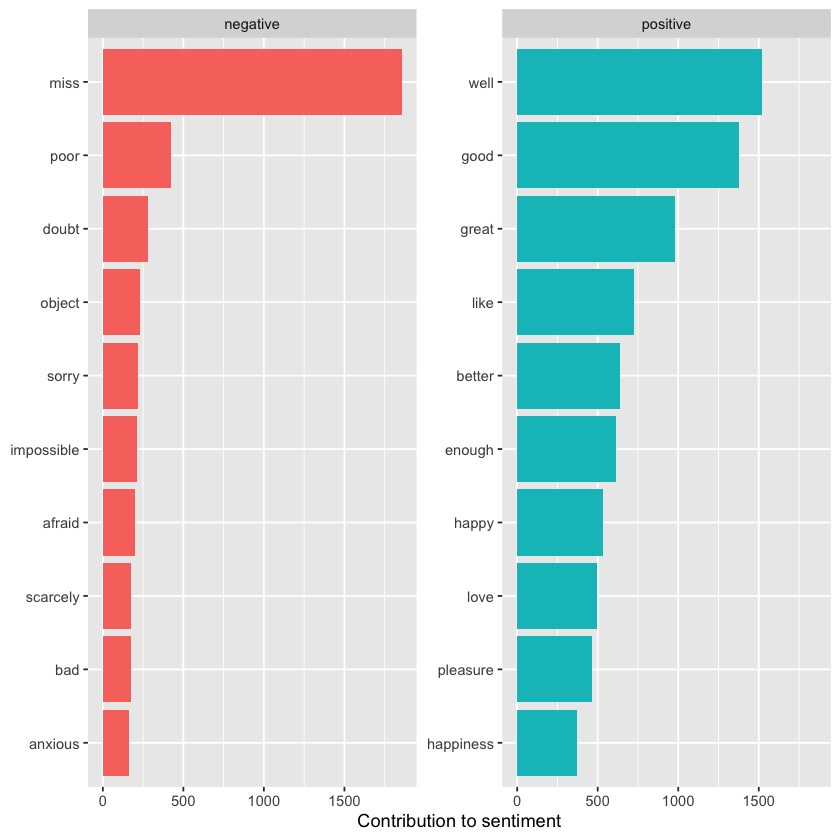

In [21]:
bing_word_counts %>%
  group_by(sentiment) %>%
  slice_max(n, n = 10) %>% 
  ungroup() %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word, fill = sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment, scales = "free_y") +
  labs(x = "Contribution to sentiment",
       y = NULL)

This reveals an anomaly in the sentiment analysis—the word “miss” is marked as negative, even though in Jane Austen’s works it is commonly used as a title for young, unmarried women. If needed for our analysis, we could easily add “miss” to a custom stop words list using [`bind_rows()`](https://dplyr.tidyverse.org/reference/bind_rows.html). This could be done with an approach like the one shown here.


In [22]:
custom_stop_words <- bind_rows(tibble(word = c("miss"),  
                                      lexicon = c("custom")), 
                               stop_words)

print(custom_stop_words)

# A tibble: 1,150 x 2
   word        lexicon
   <chr>       <chr>  
 1 miss        custom 
 2 a           SMART  
 3 a's         SMART  
 4 able        SMART  
 5 about       SMART  
 6 above       SMART  
 7 according   SMART  
 8 accordingly SMART  
 9 across      SMART  
10 actually    SMART  
# i 1,140 more rows


### Wordclouds

We’ve seen that the tidy text mining approach integrates well with **ggplot2**, but having our data in a tidy format is also helpful for creating other types of visualizations.

For instance, we can use the **wordcloud** package, which relies on base R graphics. Let’s revisit the most common words across Jane Austen’s works, but display them as a word cloud.


Joining with `by = join_by(word)`


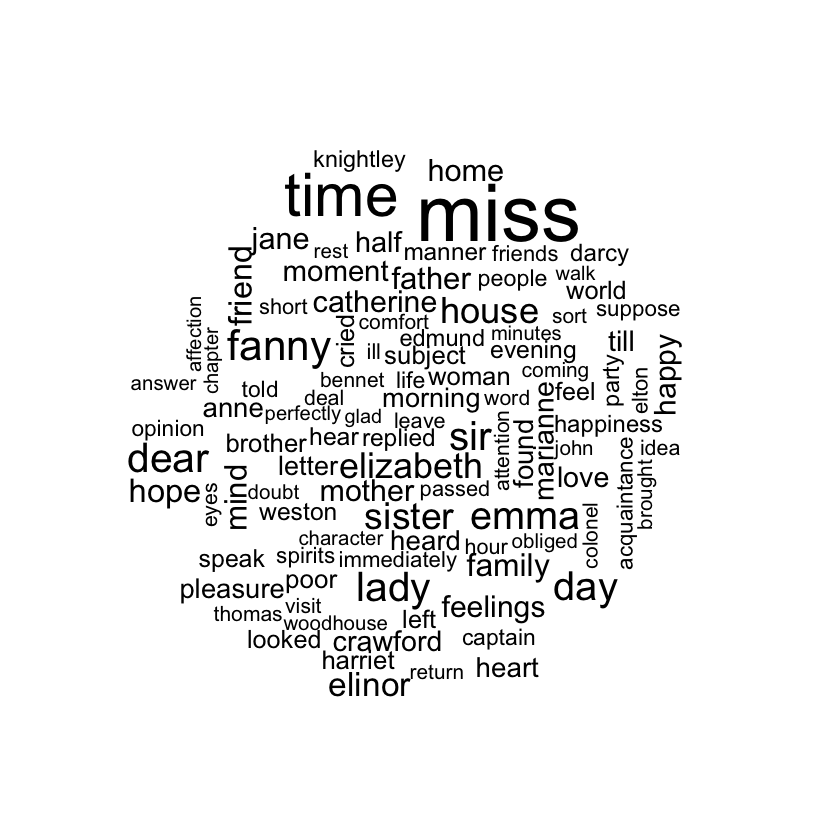

In [ ]:
library(wordcloud)

tidy_books %>%
  anti_join(stop_words) %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 100))

For functions like [`comparison.cloud()`](https://rdrr.io/cran/wordcloud/man/comparison.cloud.html), the data frame often needs to be converted into a matrix using reshape2's [`acast()`](https://rdrr.io/cran/reshape2/man/cast.html) function. To prepare for this, we first perform sentiment analysis by tagging positive and negative words with an inner_join, followed by finding the most common positive and negative words. Up to the point where we pass the data to [`comparison.cloud()`](https://rdrr.io/cran/wordcloud/man/comparison.cloud.html), all of this can be done seamlessly using joins, piping, and **dplyr**, thanks to having the data structured in a tidy format.

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("bing")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 435443 of `x` matches multiple rows in `y`.
i Row 5051 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


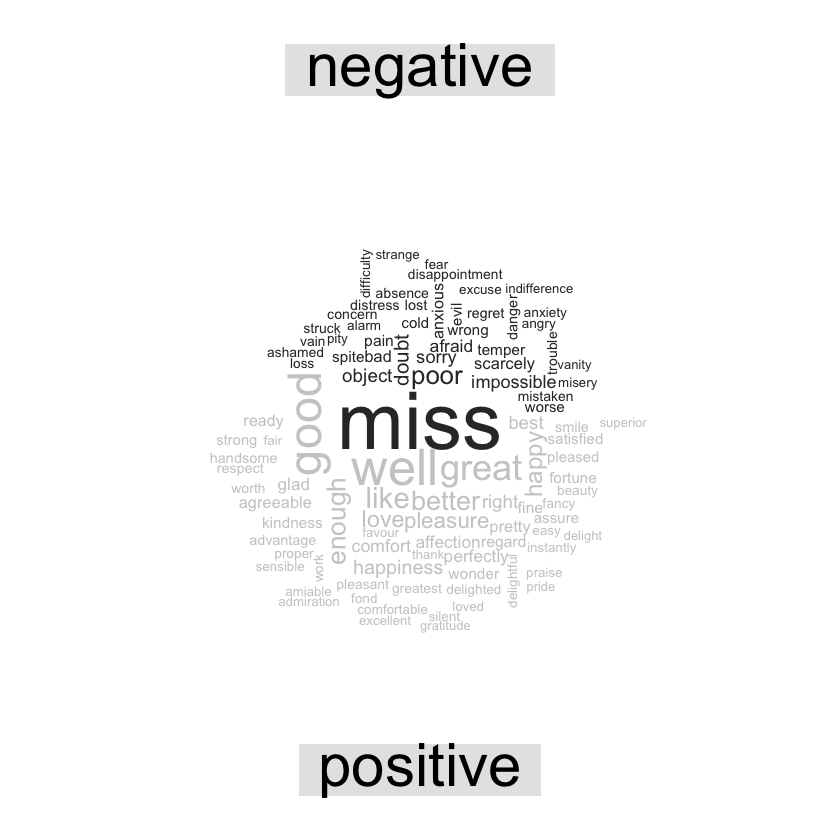

In [145]:
library(reshape2)

tidy_books %>%
  inner_join(get_sentiments("bing")) %>%
  count(word, sentiment, sort = TRUE) %>%
  acast(word ~ sentiment, value.var = "n", fill = 0) %>%
  comparison.cloud(colors = c("gray20", "gray80"),
                   max.words = 100)

The size of each word corresponds to its frequency within its assigned sentiment group. This allows us to easily identify the most prominent positive and negative words. However, keep in mind that word sizes are scaled separately within each sentiment, so the sizes are not directly comparable across positive and negative categories.


### Looking Beyond just Words

While much useful analysis can be done by tokenizing text at the word level, there are situations where other units of text are more appropriate. For example, some sentiment analysis algorithms go beyond unigrams (single words) to assess the sentiment of an entire sentence. These methods can account for context, such as negation, recognizing that:

*I am not having a good day.*

is a negative sentence, despite containing words like *good*. R packages like **coreNLP** [(T. Arnold and Tilton 2016)](https://www.tidytextmining.com/references#ref-R-coreNLP), **cleanNLP** [(T. B. Arnold 2016)](https://www.tidytextmining.com/references#ref-R-cleanNLP), and **sentimentr** [(Rinker 2017)](https://www.tidytextmining.com/references#ref-R-sentimentr) handle this type of sentiment analysis. In these cases, it’s common to tokenize by sentence and use a different output column name to reflect the change in text unit.

In [25]:
p_and_p_sentences <- tibble(text = prideprejudice) %>% 
  unnest_tokens(sentence, text, token = "sentences")

Let’s look at just one.

In [26]:
p_and_p_sentences$sentence[2]

[1] "by jane austen"

Sentence tokenizing can sometimes struggle with UTF-8 encoded text, especially in sections of dialogue, but tends to perform better with ASCII punctuation. If this causes issues, one solution is to use [`iconv()`](https://rdrr.io/r/base/iconv.html) to convert the text encoding, for example with `iconv(text, to = 'latin1')` inside a mutate statement before unnesting.

Another option with [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) is to split the text into tokens using a regular expression. For instance, we could use this approach to break Jane Austen’s novels into a data frame by chapter based on a chapter header pattern.


In [27]:
austen_chapters <- austen_books() %>%
  group_by(book) %>%
  unnest_tokens(chapter, text, token = "regex", 
                pattern = "Chapter|CHAPTER [\\dIVXLC]") %>%
  ungroup()

austen_chapters %>% 
  group_by(book) %>% 
  summarise(chapters = n()) %>%
  print()

# A tibble: 6 x 2
  book                chapters
  <fct>                  <int>
1 Sense & Sensibility       51
2 Pride & Prejudice         62
3 Mansfield Park            49
4 Emma                      56
5 Northanger Abbey          32
6 Persuasion                25


We’ve successfully recovered the correct number of chapters for each novel (with one extra row for each title), and in the `austen_chapters` data frame, each row now represents a chapter.

Earlier, we used a similar regex pattern to locate chapter breaks when tokenizing text into one-word-per-row format. Now, using this tidy structure, we can explore questions like: *Which chapters in Jane Austen’s novels are the most negative?*

To answer this, we start by retrieving the list of negative words from the **bing** lexicon. Then, we create a data frame that counts the total number of words per chapter—this helps us normalize for chapter length. Next, we count how many negative words appear in each chapter and divide that by the total number of words in that chapter. Finally, we identify which chapter in each book has the highest **proportion** of negative words.

In [28]:
bingnegative <- get_sentiments("bing") %>% 
  filter(sentiment == "negative")

wordcounts <- tidy_books %>%
  group_by(book, chapter) %>%
  summarize(words = n())

tidy_books %>%
  semi_join(bingnegative) %>%
  group_by(book, chapter) %>%
  summarize(negativewords = n()) %>%
  left_join(wordcounts, by = c("book", "chapter")) %>%
  mutate(ratio = negativewords/words) %>%
  filter(chapter != 0) %>%
  slice_max(ratio, n = 1) %>% 
  ungroup() %>%
  print()

`summarise()` has grouped output by 'book'. You can override using the
`.groups` argument.
Joining with `by = join_by(word)`
`summarise()` has grouped output by 'book'. You can override using the
`.groups` argument.


# A tibble: 6 x 5
  book                chapter negativewords words  ratio
  <fct>                 <int>         <int> <int>  <dbl>
1 Sense & Sensibility      43           161  3405 0.0473
2 Pride & Prejudice        34           111  2104 0.0528
3 Mansfield Park           46           173  3685 0.0469
4 Emma                     15           151  3340 0.0452
5 Northanger Abbey         21           149  2982 0.0500
6 Persuasion                4            62  1807 0.0343


The chapters with the highest proportion of negative words correspond to some of the most emotionally intense moments in each novel. For example, in Chapter 43 of *Sense and Sensibility*, Marianne is gravely ill and near death, while Chapter 34 of *Pride and Prejudice* features Mr. Darcy’s awkward first marriage proposal. Chapter 46 of *Mansfield Park* reveals Henry’s scandalous adultery near the story’s end, and in Chapter 15 of *Emma*, the unsettling Mr. Elton makes a proposal. In Chapter 21 of *Northanger Abbey*, Catherine is deeply caught up in her Gothic-inspired fantasies of murder, and Chapter 4 of *Persuasion* presents Anne’s painful flashback of refusing Captain Wentworth and her regret over that decision. These peaks in negative sentiment align closely with pivotal and often sorrowful moments in Austen’s narratives.

## Analyzing Word and Document Frequency

A key question in text mining and natural language processing is how to quantify what a document is about by examining its words. One simple measure is *term frequency (tf)*, which counts how often a word appears in a document. However, some frequently occurring words like “the,” “is,” and “of” may not carry much meaningful information. While removing such stop words is common, this approach can be overly simplistic, since these words might be important in certain contexts.

A more nuanced method involves *inverse document frequency (idf)*, which downweights words that appear in many documents and upweights rarer terms. Combining tf and idf gives us *tf-idf* a measure of how important a word is to a specific document within a larger collection. Although tf-idf is a heuristic rather than a theoretically rigorous measure, it has proven very useful in text mining and search engines.

Mathematically, idf for a term is defined as the natural logarithm of the total number of documents divided by the number of documents containing that term. Using tidy data principles, as introduced in Chapter 1, we can efficiently calculate and analyze tf-idf scores to identify key terms that define individual documents within a corpus.


### Term Frequency in Jane Austen's Novels

Let’s begin by exploring Jane Austen’s published novels to analyze term frequency and then tf-idf. Using **dplyr** functions like [`group_by()`](https://dplyr.tidyverse.org/reference/group_by.html) and `join()`, we can identify the most commonly used words across her works. At the same time, we’ll calculate the total number of words in each novel, which will be useful later when we compute tf-idf scores. This approach helps us understand word importance both within individual novels and across the entire collection.

In [ ]:
library(dplyr)
library(janeaustenr)
library(tidytext)

book_words <- austen_books() %>%
  unnest_tokens(word, text) %>%
  count(book, word, sort = TRUE)

total_words <- book_words %>% 
  group_by(book) %>% 
  summarize(total = sum(n))

book_words <- left_join(book_words, total_words)

print(book_words)

Joining with `by = join_by(book)`


# A tibble: 40,378 x 4
   book              word      n  total
   <fct>             <chr> <int>  <int>
 1 Mansfield Park    the    6206 160465
 2 Mansfield Park    to     5475 160465
 3 Mansfield Park    and    5438 160465
 4 Emma              to     5239 160996
 5 Emma              the    5201 160996
 6 Emma              and    4896 160996
 7 Mansfield Park    of     4778 160465
 8 Pride & Prejudice the    4331 122204
 9 Emma              of     4291 160996
10 Pride & Prejudice to     4162 122204
# i 40,368 more rows


The `book_words` data frame has one row for each word–book pair; the column `n` shows how many times that word appears in the book, and `total` is the total number of words in that book. Unsurprisingly, the most frequent words include common ones like “the,” “and,” and “to.”

We can visualize the distribution of `n/total` for each novel—this ratio represents the term frequency, showing how often a word occurs relative to the total words in that novel.

These plots have long right tails—representing those very common words—which aren’t fully displayed here. Overall, the distributions are similar across all the novels, showing many words that appear infrequently and only a few that occur very frequently.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 896 rows containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_bar()`)."


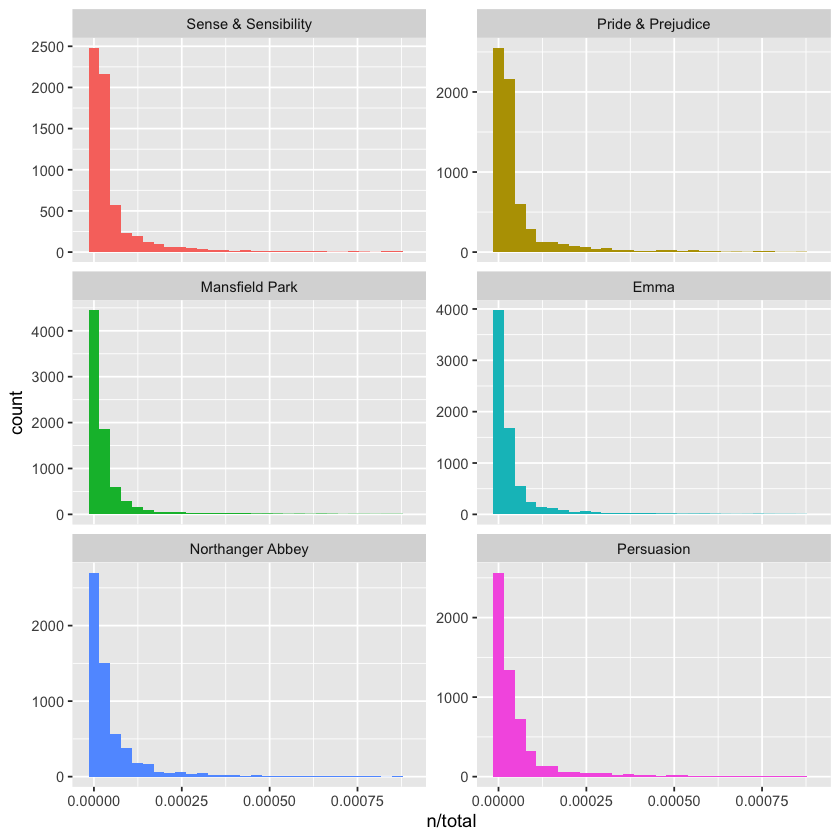

In [ ]:
library(ggplot2)

ggplot(book_words, aes(n/total, fill = book)) +
  geom_histogram(show.legend = FALSE) +
  xlim(NA, 0.0009) +
  facet_wrap(~book, ncol = 2, scales = "free_y")

### Zipf’s Law

Distributions like those above are typical in natural language. In fact, these long-tailed patterns are so common in any text corpus—whether a book, website content, or spoken language—that the relationship between a word’s frequency and its rank has been extensively studied. This relationship is famously described by Zipf’s law, named after George Zipf, a 20th-century American linguist.

Zipf’s law states that a word’s frequency is roughly **inversely proportional** to its rank in the frequency list. Since we already have the data frame used to plot term frequencies, we can easily explore Zipf’s law for Jane Austen’s novels using just a few lines of **dplyr** code.


In [31]:
freq_by_rank <- book_words %>% 
  group_by(book) %>% 
  mutate(rank = row_number(), 
         term_frequency = n/total) %>%
  ungroup()

print(freq_by_rank)

# A tibble: 40,378 x 6
   book              word      n  total  rank term_frequency
   <fct>             <chr> <int>  <int> <int>          <dbl>
 1 Mansfield Park    the    6206 160465     1         0.0387
 2 Mansfield Park    to     5475 160465     2         0.0341
 3 Mansfield Park    and    5438 160465     3         0.0339
 4 Emma              to     5239 160996     1         0.0325
 5 Emma              the    5201 160996     2         0.0323
 6 Emma              and    4896 160996     3         0.0304
 7 Mansfield Park    of     4778 160465     4         0.0298
 8 Pride & Prejudice the    4331 122204     1         0.0354
 9 Emma              of     4291 160996     4         0.0267
10 Pride & Prejudice to     4162 122204     2         0.0341
# i 40,368 more rows


The `rank` column assigns each word its position in the frequency table, which is ordered by `n` (the count), and we can use [`row_number()`](https://dplyr.tidyverse.org/reference/row_number.html) to generate these ranks. After that, we calculate the term frequency just as before. Zipf’s law is typically visualized by plotting rank on the x-axis and term frequency on the y-axis, both using logarithmic scales. When plotted this way, the inverse relationship predicted by Zipf’s law appears as a straight line with a constant negative slope.


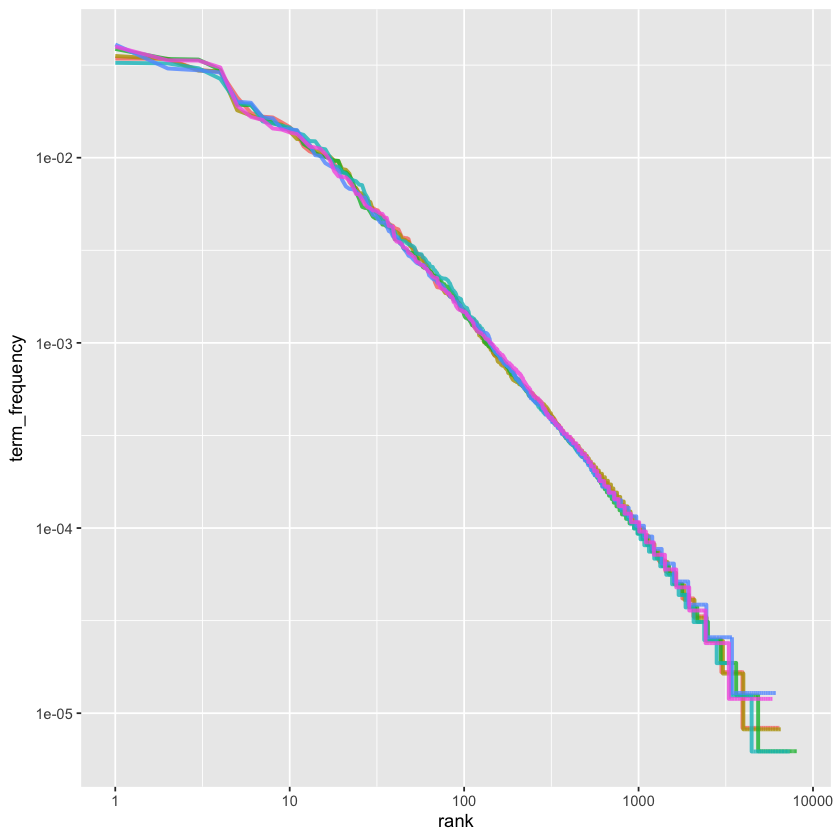

In [32]:
freq_by_rank %>% 
  ggplot(aes(rank, term_frequency, color = book)) + 
  geom_line(linewidth = 1.1, alpha = 0.8, show.legend = FALSE) + 
  scale_x_log10() +
  scale_y_log10()

The graph is plotted using log-log coordinates, showing that all six of Jane Austen’s novels follow similar patterns where the relationship between rank and frequency has a clear negative slope. However, this slope isn’t perfectly constant—suggesting the distribution might be better described as a broken [power law](https://en.wikipedia.org/wiki/Power_law) divided into, say, three sections. To explore this further, let’s focus on the middle section of the rank range and calculate the exponent of the power law there.


In [33]:
rank_subset <- freq_by_rank %>% 
  filter(rank < 500,
         rank > 10)

lm(log10(term_frequency) ~ log10(rank), data = rank_subset)


Call:
lm(formula = log10(term_frequency) ~ log10(rank), data = rank_subset)

Coefficients:
(Intercept)  log10(rank)  
    -0.6226      -1.1125  


Classic Zipf’s law states that frequency is proportional to 1 divided by rank, which corresponds to a slope of about -1 on a log-log plot. Since our calculated slope is close to -1, let’s plot this fitted power law alongside the data from above to visually compare how well it matches.


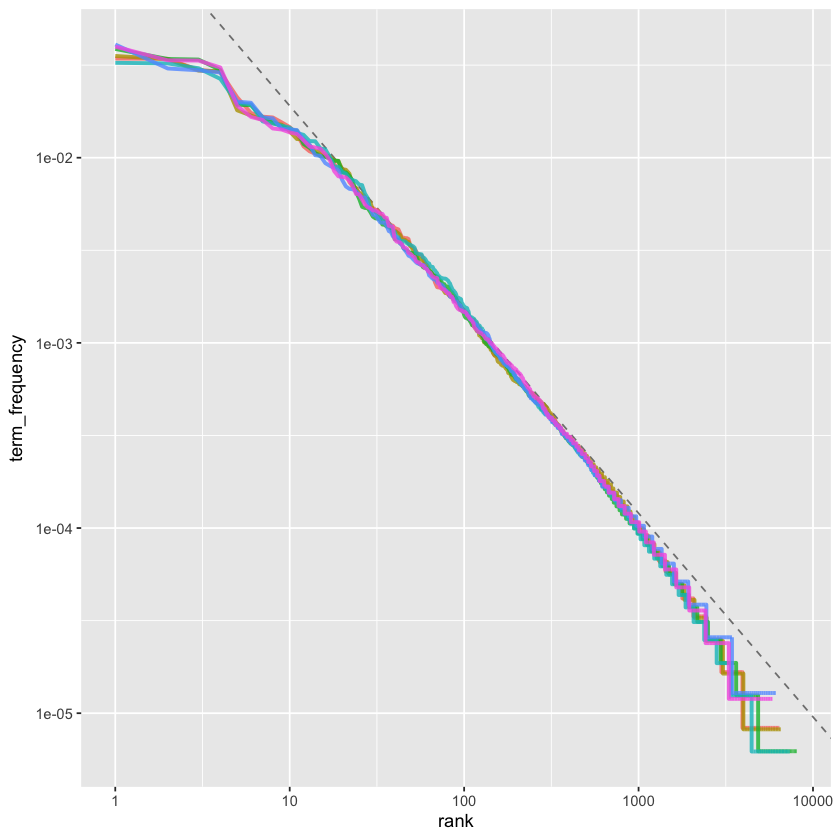

In [34]:
freq_by_rank %>% 
  ggplot(aes(rank, term_frequency, color = book)) + 
  geom_abline(intercept = -0.62, slope = -1.1, 
              color = "gray50", linetype = 2) +
  geom_line(linewidth = 1.1, alpha = 0.8, show.legend = FALSE) + 
  scale_x_log10() +
  scale_y_log10()

Our analysis of Jane Austen’s novels reveals a result close to the classic Zipf’s law. The deviations at high ranks—where fewer rare words appear than a single power law would predict—are typical in many language corpora. However, the deviations at low ranks are more unusual: Austen uses a smaller proportion of the very most common words compared to many other text collections. This type of analysis can be easily extended to compare different authors or other text collections, all while leveraging the simplicity and power of tidy data principles.

### The `bind_tf_idf()` Function

The idea behind *tf-idf* is to identify the most important words in each document by reducing the weight of very common words and increasing the weight of words that are relatively rare across the whole collection—in this case, Jane Austen’s novels as a group. Calculating *tf-idf* helps highlight words that are frequent within a specific text but not overused across the entire corpus.

To do this, we use the [`bind_tf_idf()`](https://juliasilge.github.io/tidytext/reference/bind_tf_idf.html) function from the **tidytext** package, which takes a tidy text dataset as input. The dataset should have one row per token (word) per document. It needs a column with the terms (like `word`), a column identifying the documents (like `book`), and a column with the counts of each term in each document (`n`). Although we previously calculated totals for each book, [`bind_tf_idf()`](https://juliasilge.github.io/tidytext/reference/bind_tf_idf.html) doesn’t require those—just the complete list of words and their counts for each document.

In [35]:
book_tf_idf <- book_words %>%
  bind_tf_idf(word, book, n)

print(book_tf_idf)

# A tibble: 40,378 x 7
   book              word      n  total     tf   idf tf_idf
   <fct>             <chr> <int>  <int>  <dbl> <dbl>  <dbl>
 1 Mansfield Park    the    6206 160465 0.0387     0      0
 2 Mansfield Park    to     5475 160465 0.0341     0      0
 3 Mansfield Park    and    5438 160465 0.0339     0      0
 4 Emma              to     5239 160996 0.0325     0      0
 5 Emma              the    5201 160996 0.0323     0      0
 6 Emma              and    4896 160996 0.0304     0      0
 7 Mansfield Park    of     4778 160465 0.0298     0      0
 8 Pride & Prejudice the    4331 122204 0.0354     0      0
 9 Emma              of     4291 160996 0.0267     0      0
10 Pride & Prejudice to     4162 122204 0.0341     0      0
# i 40,368 more rows


Notice that the *inverse document frequency (idf)*, and therefore *tf-idf*, is zero for extremely common words that appear in all six of Jane Austen’s novels. This happens because the *idf* is calculated as the natural logarithm of the total number of documents divided by the number of documents containing the word—so when a word appears in every document, that ratio is 1, and log(1) equals zero. As a result, common words get very low or zero tf-idf scores, which reduces their importance in the analysis.

In contrast, words that appear in fewer documents have higher idf values, boosting their *tf-idf* scores and highlighting their uniqueness to particular texts. Let’s now explore which terms have the highest tf-idf values in Jane Austen’s works.


In [36]:
book_tf_idf %>%
  select(-total) %>%
  arrange(desc(tf_idf)) %>%
  print()

# A tibble: 40,378 x 6
   book                word          n      tf   idf  tf_idf
   <fct>               <chr>     <int>   <dbl> <dbl>   <dbl>
 1 Sense & Sensibility elinor      623 0.00519  1.79 0.00931
 2 Sense & Sensibility marianne    492 0.00410  1.79 0.00735
 3 Mansfield Park      crawford    493 0.00307  1.79 0.00550
 4 Pride & Prejudice   darcy       373 0.00305  1.79 0.00547
 5 Persuasion          elliot      254 0.00304  1.79 0.00544
 6 Emma                emma        786 0.00488  1.10 0.00536
 7 Northanger Abbey    tilney      196 0.00252  1.79 0.00452
 8 Emma                weston      389 0.00242  1.79 0.00433
 9 Pride & Prejudice   bennet      294 0.00241  1.79 0.00431
10 Persuasion          wentworth   191 0.00228  1.79 0.00409
# i 40,368 more rows


Here, we observe mostly proper nouns—names that are indeed significant in these novels. Since none of these names appear in all six novels, they receive higher *tf-idf scores*, making them distinctive and characteristic terms for each individual book within Jane Austen’s corpus.

Some *idf* values repeat because the corpus has six documents, so the values correspond to the natural logarithms of ratios like ln(6/1), ln(6/2), and so on. 

Next, let’s visualize these high tf-idf words to better understand their importance across the novels.


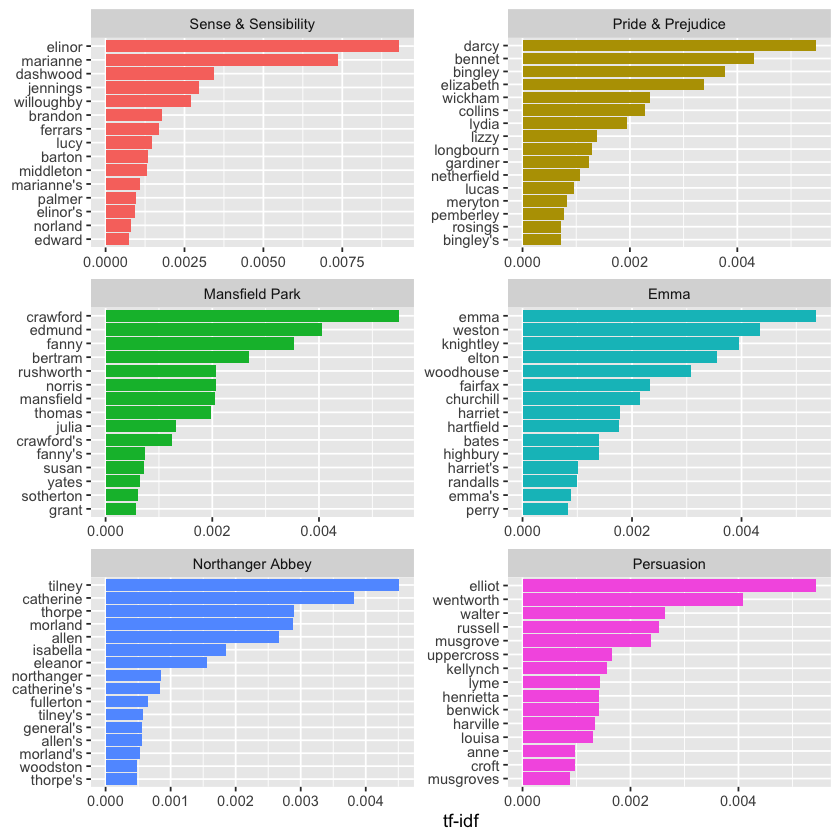

In [ ]:
library(forcats)

book_tf_idf %>%
  group_by(book) %>%
  slice_max(tf_idf, n = 15) %>%
  ungroup() %>%
  ggplot(aes(tf_idf, fct_reorder(word, tf_idf), fill = book)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free") +
  labs(x = "tf-idf", y = NULL)

These still highlight mainly proper nouns! These words, identified by their *high tf-idf scores*, are the most important and distinctive terms for each novel—something most readers would agree with. What *tf-idf* reveals here is that Jane Austen’s language is quite consistent across her six novels, and the key differences that set each novel apart are the proper nouns—the names of characters and places. This perfectly illustrates the purpose of *tf-idf*: to pinpoint words that are especially significant to individual documents within a larger collection.

### A Corpus of Physics Texts

Let’s explore a different set of documents to see which terms stand out as important. Stepping away from fiction and narrative, we’ll download several classic physics texts from Project Gutenberg: [*Discourse on Floating Bodies* by Galileo Galilei](https://www.gutenberg.org/ebooks/37729), [*Treatise on Light* by Christiaan Huygens](https://www.gutenberg.org/ebooks/14725), [*Experiments with Alternate Currents of High Potential and High Frequency* by Nikola Tesla](https://www.gutenberg.org/ebooks/13476), and [*Relativity: The Special and General Theory* by Albert Einstein](https://www.gutenberg.org/ebooks/30155).

This collection is quite diverse—these physics classics span over 300 years, and some were originally written in other languages before being translated into English. While not perfectly uniform, this variety makes for a fascinating analysis of important terms using *tf-idf*.

In [ ]:
library(gutenbergr)

physics <- gutenberg_download(c(37729, 14725, 13476, 30155), 
                              meta_fields = "author")

Now that we have the texts, let’s use [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) and [`count()`](https://dplyr.tidyverse.org/reference/count.html) to find out how many times each word was used in each text.

In [39]:
physics_words <- physics %>%
  unnest_tokens(word, text) %>%
  count(author, word, sort = TRUE)

print(physics_words)

# A tibble: 12,664 x 3
   author              word      n
   <chr>               <chr> <int>
 1 Galilei, Galileo    the    3760
 2 Tesla, Nikola       the    3604
 3 Huygens, Christiaan the    3553
 4 Einstein, Albert    the    2993
 5 Galilei, Galileo    of     2049
 6 Einstein, Albert    of     2029
 7 Tesla, Nikola       of     1737
 8 Huygens, Christiaan of     1708
 9 Huygens, Christiaan to     1207
10 Tesla, Nikola       a      1177
# i 12,654 more rows


Here we are looking at just the raw word counts, but it's important to keep in mind that these documents vary greatly in length. To better understand which terms are truly important relative to the size of each text, we calculate the *tf-idf scores*. This adjusts for document length and highlights distinctive words in each text. After calculating *tf-idf*, we can visualize the words with the highest tf-idf values to see which terms stand out most in each physics classic.

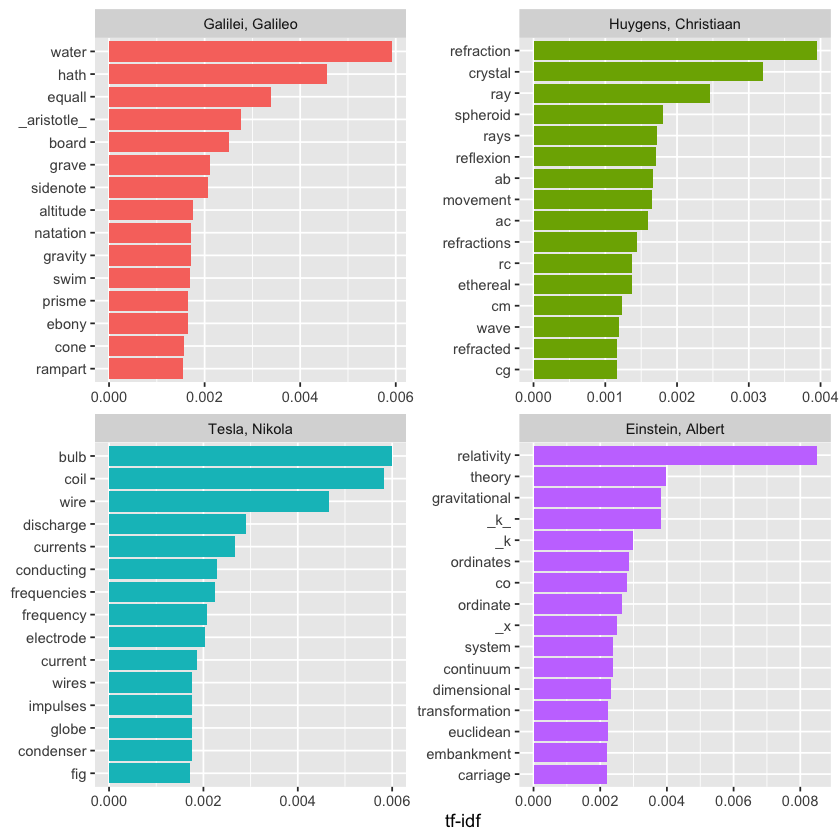

In [40]:
plot_physics <- physics_words %>%
  bind_tf_idf(word, author, n) %>%
  mutate(author = factor(author, levels = c("Galilei, Galileo",
                                            "Huygens, Christiaan", 
                                            "Tesla, Nikola",
                                            "Einstein, Albert")))

plot_physics %>% 
  group_by(author) %>% 
  slice_max(tf_idf, n = 15) %>% 
  ungroup() %>%
  mutate(word = reorder(word, tf_idf)) %>%
  ggplot(aes(tf_idf, word, fill = author)) +
  geom_col(show.legend = FALSE) +
  labs(x = "tf-idf", y = NULL) +
  facet_wrap(~author, ncol = 2, scales = "free")

Yeah, that definitely catches the eye! The letter “k” showing up with a high tf-idf score in Einstein’s text probably means it’s a key technical term or variable used frequently in *Relativity: The Special and General Theory* but not much elsewhere. In physics and math, single letters like “k” often represent constants, coefficients, or variables, so it makes sense it would stand out compared to other documents. It’s a neat example of how tf-idf highlights terms that are uniquely important to a specific document! Want to dig into what “k” represents in Einstein’s work?

In [ ]:
library(stringr)

physics %>% 
  filter(str_detect(text, "_k_")) %>% 
  select(text) %>%
  print()

# A tibble: 7 x 1
  text                                                                         
  <chr>                                                                        
1 "surface AB at the points AK_k_B. Then instead of the hemispherical"         
2 "would needs be that from all the other points K_k_B there should"           
3 "necessarily be equal to CD, because C_k_ is equal to CK, and C_g_ to"       
4 "the crystal at K_k_, all the points of the wave CO_oc_ will have"           
5 "O_o_ has reached K_k_. Which is easy to comprehend, since, of these"        
6 "CO_oc_ in the crystal, when O_o_ has arrived at K_k_, because it forms"     
7 "\u03c1 is the average density of the matter and _k_ is a constant connected"


Some text cleaning may be necessary. Also, notice that “co” and “ordinate” appear separately among the high tf-idf words for Einstein’s text; this happens because [`unnest_tokens()](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) by default splits on punctuation such as hyphens. The tf-idf values for “co” and “ordinate” are nearly identical!

Additionally, abbreviations like “AB” and “RC” refer to names of rays, circles, angles, and similar concepts in Huygens’ work.


In [42]:
physics %>% 
  filter(str_detect(text, "RC")) %>% 
  select(text) %>%
  print()

# A tibble: 44 x 1
   text                                                                  
   <chr>                                                                 
 1 line RC, parallel and equal to AB, to be a portion of a wave of light,
 2 represents the partial wave coming from the point A, after the wave RC
 3 be the propagation of the wave RC which fell on AB, and would be the  
 4 transparent body; seeing that the wave RC, having come to the aperture
 5 incident rays. Let there be such a ray RC falling upon the surface    
 6 CK. Make CO perpendicular to RC, and across the angle KCO adjust OK,  
 7 the required refraction of the ray RC. The demonstration of this is,  
 8 explaining ordinary refraction. For the refraction of the ray RC is   
 9 29. Now as we have found CI the refraction of the ray RC, similarly   
10 the ray _r_C is inclined equally with RC, the line C_d_ will          
# i 34 more rows


To create a clearer and more meaningful plot, let’s remove some of these less relevant words. We do this by creating a custom list of stop words and applying [`anti_join()`](https://dplyr.tidyverse.org/reference/filter-joins.html) to filter them out. This method is flexible and can be adapted to various situations. Since we’re removing words from the tidy data frame, we’ll need to revisit some earlier steps in the process.

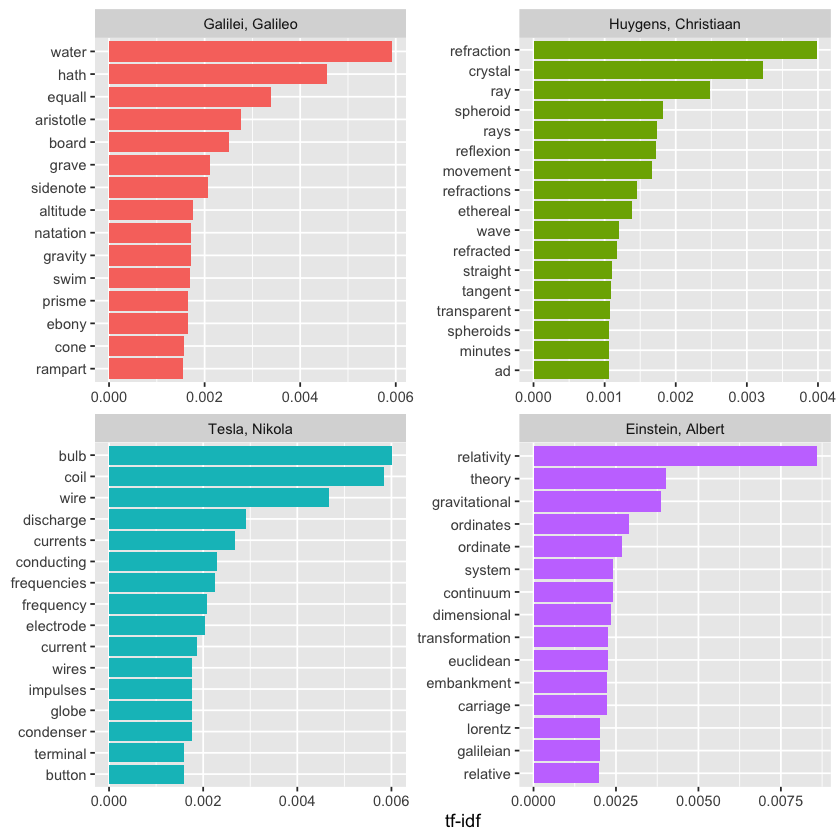

In [43]:
mystopwords <- tibble(word = c("eq", "co", "rc", "ac", "ak", "bn", 
                                   "fig", "file", "cg", "cb", "cm",
                               "ab", "_k", "_k_", "_x"))

physics_words <- anti_join(physics_words, mystopwords, 
                           by = "word")

plot_physics <- physics_words %>%
  bind_tf_idf(word, author, n) %>%
  mutate(word = str_remove_all(word, "_")) %>%
  group_by(author) %>% 
  slice_max(tf_idf, n = 15) %>%
  ungroup() %>%
  mutate(word = fct_reorder(word, tf_idf)) %>%
  mutate(author = factor(author, levels = c("Galilei, Galileo",
                                            "Huygens, Christiaan",
                                            "Tesla, Nikola",
                                            "Einstein, Albert")))

ggplot(plot_physics, aes(tf_idf, word, fill = author)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~author, ncol = 2, scales = "free") +
  labs(x = "tf-idf", y = NULL)

One takeaway from this is that modern physics discussions rarely mention ramparts or describe things as ethereal.

The examples from Jane Austen and physics in this chapter showed little overlap in high tf-idf words across different categories like books or authors. However, if you do encounter shared high tf-idf words across categories, you might consider using [`reorder_within()`](https://juliasilge.github.io/tidytext/reference/reorder_within.html) and `scale_*_reordered()` to create clearer visualizations. 

## Relationships Between Words

Up to this point, we’ve treated words as individual units and explored how they relate to sentiments or documents. However, much of text analysis focuses on the relationships between words — such as which words tend to appear next to one another or co-occur within the same text.

In this chapter, we’ll look at tidytext methods for calculating and visualizing word relationships within the dataset. This includes using `token = "ngrams"` to break text into pairs of adjacent words instead of single words. We’ll also introduce two helpful packages: [ggraph](https://github.com/thomasp85/ggraph), which builds network plots based on ggplot2, and [widyr](https://github.com/juliasilge/widyr), which calculates pairwise correlations and distances in tidy data frames. These tools expand how we can explore text data within the tidy framework.

### Tokenizing by n-gram

So far, we’ve used `unnest_tokens()` to break text into individual words or sentences, which works well for sentiment and frequency analysis. However, we can also use this function to create sequences of consecutive words, known as *n-grams*. By analyzing how often one word follows another, we can better understand the relationships between words.

To do this, we simply add `token = "ngrams"` to [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) and set `n` to the number of consecutive words we want to group. When `n = 2`, we generate pairs of consecutive words, commonly referred to as **bigrams**.

In [ ]:
library(dplyr)
library(tidytext)
library(janeaustenr)

austen_bigrams <- austen_books() %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
  filter(!is.na(bigram))

print(austen_bigrams)

# A tibble: 662,792 x 2
   book                bigram         
   <fct>               <chr>          
 1 Sense & Sensibility sense and      
 2 Sense & Sensibility and sensibility
 3 Sense & Sensibility by jane        
 4 Sense & Sensibility jane austen    
 5 Sense & Sensibility chapter 1      
 6 Sense & Sensibility the family     
 7 Sense & Sensibility family of      
 8 Sense & Sensibility of dashwood    
 9 Sense & Sensibility dashwood had   
10 Sense & Sensibility had long       
# i 662,782 more rows


This structure remains consistent with the tidy text format, where each row represents one token, but in this case, the tokens are bigrams rather than individual words. Additional information, like the book name, is still included.

It’s important to note that these bigrams overlap — for example, “sense and” is one token, and “and sensibility” is the next.


#### Counting and Filtering n-grams

The same tidy tools we've been using for single words work just as well for n-gram analysis. We can use functions like [`count()`](https://dplyr.tidyverse.org/reference/count.html) from dplyr to easily find the most common bigrams in the text.

In [45]:
austen_bigrams %>%
  count(bigram, sort = TRUE) %>%
  print()

# A tibble: 193,212 x 2
   bigram       n
   <chr>    <int>
 1 of the    2853
 2 to be     2670
 3 in the    2221
 4 it was    1691
 5 i am      1485
 6 she had   1405
 7 of her    1363
 8 to the    1315
 9 she was   1309
10 had been  1206
# i 193,202 more rows


As expected, many of the most frequent bigrams consist of common, uninformative words like "of the" or "to be," which are considered stop words. To clean this up, we can use [`separate()`](https://tidyr.tidyverse.org/reference/separate.html) from tidyr to split the bigrams into two columns—`word1` and `word2`—allowing us to filter out any bigrams where either word is a stop word.


In [146]:
library(tidyr)

bigrams_separated <- austen_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")

bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)

# new bigram counts:
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE)

print(bigram_counts)

# A tibble: 28,971 x 3
   word1   word2         n
   <chr>   <chr>     <int>
 1 sir     thomas      266
 2 miss    crawford    196
 3 captain wentworth   143
 4 miss    woodhouse   143
 5 frank   churchill   114
 6 lady    russell     110
 7 sir     walter      108
 8 lady    bertram     101
 9 miss    fairfax      98
10 colonel brandon      96
# i 28,961 more rows


We notice that many of the most frequent bigrams in Jane Austen's novels are names, either full names or names paired with titles like "Mr." or "Miss."

In some cases, though, we might want to work with the bigrams as single, recombined units again. For that, we can use [`unite()`](https://tidyr.tidyverse.org/reference/unite.html) from tidyr, which reverses the effect of [`separate()`](https://tidyr.tidyverse.org/reference/separate.html) and merges multiple columns back into one. Using a combination of `separate()`, filtering out stop words, `count()`, and then `unite()`, we can easily identify the most frequent meaningful bigrams that exclude common stop words.


In [47]:
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")

print(bigrams_united)

# A tibble: 38,910 x 2
   book                bigram                  
   <fct>               <chr>                   
 1 Sense & Sensibility jane austen             
 2 Sense & Sensibility chapter 1               
 3 Sense & Sensibility norland park            
 4 Sense & Sensibility surrounding acquaintance
 5 Sense & Sensibility late owner              
 6 Sense & Sensibility advanced age            
 7 Sense & Sensibility constant companion      
 8 Sense & Sensibility happened ten            
 9 Sense & Sensibility henry dashwood          
10 Sense & Sensibility norland estate          
# i 38,900 more rows


For other types of analysis, you might want to focus on trigrams—sequences of three consecutive words. To extract those, you simply set `n = 3` when using `unnest_tokens()` with `token = "ngrams"`.

In [48]:
austen_books() %>%
  unnest_tokens(trigram, text, token = "ngrams", n = 3) %>%
  filter(!is.na(trigram)) %>%
  separate(trigram, c("word1", "word2", "word3"), sep = " ") %>%
  filter(!word1 %in% stop_words$word,
         !word2 %in% stop_words$word,
         !word3 %in% stop_words$word) %>%
  count(word1, word2, word3, sort = TRUE) %>%
  print()

# A tibble: 6,139 x 4
   word1     word2     word3         n
   <chr>     <chr>     <chr>     <int>
 1 dear      miss      woodhouse    20
 2 miss      de        bourgh       17
 3 lady      catherine de           11
 4 poor      miss      taylor       11
 5 sir       walter    elliot       10
 6 catherine de        bourgh        9
 7 dear      sir       thomas        8
 8 replied   miss      crawford      7
 9 sir       william   lucas         7
10 ten       thousand  pounds        7
# i 6,129 more rows


#### Analyzing bigrams

Having one bigram per row makes exploratory text analysis straightforward. For instance, we can easily investigate the most frequently mentioned "streets" in each book by filtering bigrams for those where the second word is "street" and summarizing the results.

In [49]:
bigrams_filtered %>%
  filter(word2 == "street") %>%
  count(book, word1, sort = TRUE) %>%
  print()

# A tibble: 33 x 3
   book                word1           n
   <fct>               <chr>       <int>
 1 Sense & Sensibility harley         16
 2 Sense & Sensibility berkeley       15
 3 Northanger Abbey    milsom         10
 4 Northanger Abbey    pulteney       10
 5 Mansfield Park      wimpole         9
 6 Pride & Prejudice   gracechurch     8
 7 Persuasion          milsom          5
 8 Sense & Sensibility bond            4
 9 Sense & Sensibility conduit         4
10 Persuasion          rivers          4
# i 23 more rows


We can also treat bigrams as terms within documents, similar to how we handled single words. For instance, we can calculate the *tf-idf* values for bigrams across Jane Austen's novels. These *tf-idf scores* highlight which word pairs are most characteristic of each book, and we can visualize them in the same way we previously visualized single-word *tf-idf* values.


In [50]:
bigram_tf_idf <- bigrams_united %>%
  count(book, bigram) %>%
  bind_tf_idf(bigram, book, n) %>%
  arrange(desc(tf_idf))

print(bigram_tf_idf)

# A tibble: 31,388 x 6
   book                bigram                n     tf   idf tf_idf
   <fct>               <chr>             <int>  <dbl> <dbl>  <dbl>
 1 Mansfield Park      sir thomas          266 0.0304  1.79 0.0546
 2 Persuasion          captain wentworth   143 0.0290  1.79 0.0519
 3 Mansfield Park      miss crawford       196 0.0224  1.79 0.0402
 4 Persuasion          lady russell        110 0.0223  1.79 0.0399
 5 Persuasion          sir walter          108 0.0219  1.79 0.0392
 6 Emma                miss woodhouse      143 0.0173  1.79 0.0309
 7 Northanger Abbey    miss tilney          74 0.0165  1.79 0.0295
 8 Sense & Sensibility colonel brandon      96 0.0155  1.79 0.0278
 9 Sense & Sensibility sir john             94 0.0152  1.79 0.0273
10 Pride & Prejudice   lady catherine       87 0.0139  1.79 0.0248
# i 31,378 more rows


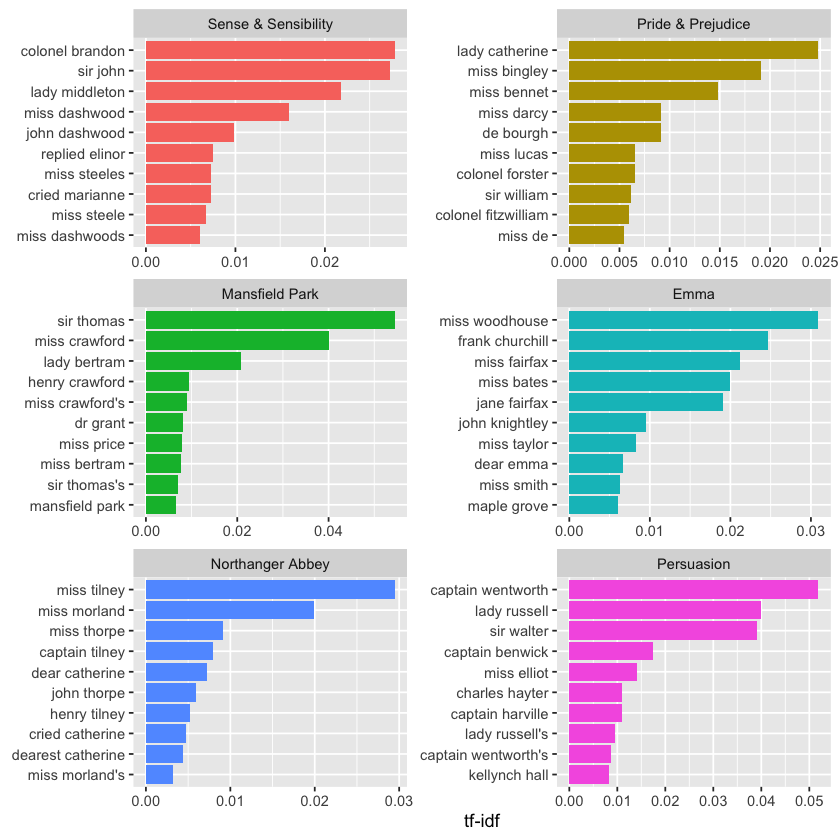

In [51]:
bigram_tf_idf %>%
  group_by(book) %>%
  slice_max(tf_idf, n = 10) %>%
  ungroup() %>%
  ggplot(aes(tf_idf, fct_reorder(bigram, tf_idf), fill = book)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free") +
  labs(x = "tf-idf", y = NULL)

Just like we saw in Chapter 3, the bigrams that distinguish each Austen novel are mostly names. We also notice some verb-name pairs, like “replied elinor” in *Sense & Sensibility* or “cried catherine” in *Northanger Abbey*.

Analyzing tf-idf for bigrams has its pros and cons. On the plus side, pairs of consecutive words can capture context and structure that single words miss—“maple grove” in *Emma*, for example, is more meaningful than just “maple.” On the downside, bigrams tend to be much rarer than individual words, so their counts are sparser. Because of this, bigrams are especially helpful when working with very large text datasets.

#### Using Bigrams to Provide Context

Our sentiment analysis method from above counted positive or negative words based on a reference lexicon. However, one issue with this approach is that context can be just as important as the word itself. For instance, words like “happy” and “like” would register as positive even in sentences like “I’m not happy and I don’t like it!”

With our data now structured as bigrams, it becomes straightforward to see how often words are preceded by negations like “not”:


In [52]:
bigrams_separated %>%
  filter(word1 == "not") %>%
  count(word1, word2, sort = TRUE) %>%
  print()

# A tibble: 1,178 x 3
   word1 word2     n
   <chr> <chr> <int>
 1 not   be      580
 2 not   to      335
 3 not   have    307
 4 not   know    237
 5 not   a       184
 6 not   think   162
 7 not   been    151
 8 not   the     135
 9 not   at      126
10 not   in      110
# i 1,168 more rows


By conducting sentiment analysis on the bigram data, we can identify how frequently sentiment-bearing words are preceded by negations like “not.” This allows us to either exclude or invert their sentiment contribution accordingly.

Let’s apply the AFINN lexicon for this analysis, which assigns numeric sentiment scores to words—positive values for positive sentiment and negative values for negative sentiment.

In [53]:
AFINN <- get_sentiments("afinn")

print(AFINN)

# A tibble: 2,477 x 2
   word       value
   <chr>      <dbl>
 1 abandon       -2
 2 abandoned     -2
 3 abandons      -2
 4 abducted      -2
 5 abduction     -2
 6 abductions    -2
 7 abhor         -3
 8 abhorred      -3
 9 abhorrent     -3
10 abhors        -3
# i 2,467 more rows


Next, we can look at which sentiment-associated words most often appear right after “not.” This helps us understand how negation affects the sentiment of those words by identifying the most frequent such bigrams.

In [54]:
not_words <- bigrams_separated %>%
  filter(word1 == "not") %>%
  inner_join(AFINN, by = c(word2 = "word")) %>%
  count(word2, value, sort = TRUE)

print(not_words)

# A tibble: 229 x 3
   word2   value     n
   <chr>   <dbl> <int>
 1 like        2    95
 2 help        2    77
 3 want        1    41
 4 wish        1    39
 5 allow       1    30
 6 care        2    21
 7 sorry      -1    20
 8 leave      -1    17
 9 pretend    -1    17
10 worth       2    17
# i 219 more rows


For instance, the word most frequently following “not” with an associated sentiment was “like,” which typically carries a positive score of 2.

It’s also insightful to identify which words contributed most to sentiment in the “wrong” direction due to negation. We calculate this by multiplying each word’s sentiment value by its frequency — so a word with a sentiment score of +3 appearing 10 times has the same impact as a word with a score of +1 appearing 30 times. We then visualize these results in a bar plot.


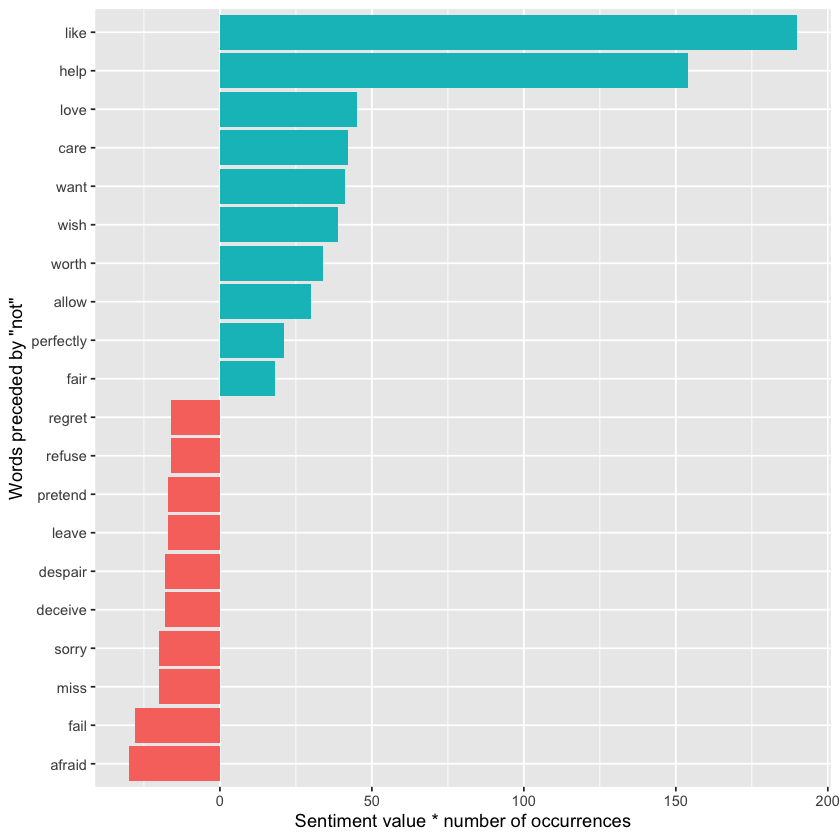

In [ ]:

library(ggplot2)

  mutate(contribution = n * value) %>%
  arrange(desc(abs(contribution))) %>%
  head(20) %>%
  mutate(word2 = reorder(word2, contribution)) %>%
  ggplot(aes(n * value, word2, fill = n * value > 0)) +
  geom_col(show.legend = FALSE) +
  labs(x = "Sentiment value * number of occurrences",
       y = "Words preceded by \"not\"")

The bigrams “not like” and “not help” were by far the biggest contributors to misclassification, causing the text to appear more positive than it actually is. However, phrases such as “not afraid” and “not fail” sometimes make the text seem more negative than intended.

“Not” isn’t the only word that modifies the sentiment of the following term. We could select four or more common negation words and apply the same join-and-count method to analyze all of them together.


In [56]:
negation_words <- c("not", "no", "never", "without")

negated_words <- bigrams_separated %>%
  filter(word1 %in% negation_words) %>%
  inner_join(AFINN, by = c(word2 = "word")) %>%
  count(word1, word2, value, sort = TRUE)

We can then create a visualization showing the most frequent words that follow each specific negation word. While “not like” and “not help” remain the top examples, we also observe pairs like “no great” and “never loved.” Combining this with the methods from before, we could invert the AFINN sentiment scores for words that come after negations. This demonstrates just a few ways that analyzing consecutive words adds valuable context to text mining techniques.

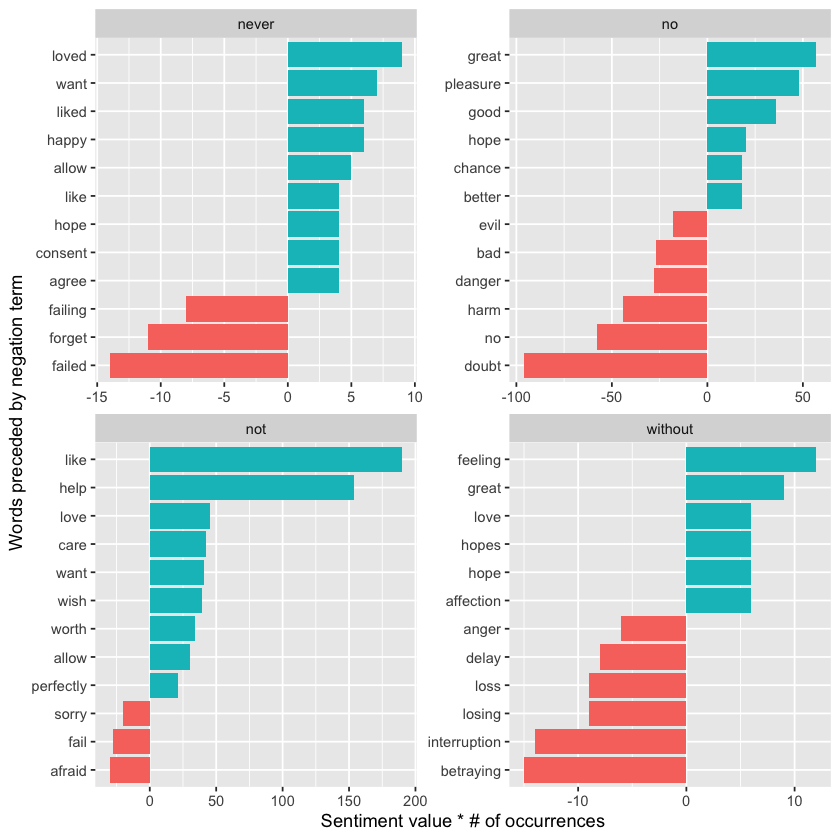

In [57]:
negated_words %>%
  mutate(contribution = n * value,
         word2 = reorder(paste(word2, word1, sep = "__"), contribution)) %>%
  group_by(word1) %>%
  slice_max(abs(contribution), n = 12, with_ties = FALSE) %>%
  ggplot(aes(word2, contribution, fill = n * value > 0)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ word1, scales = "free") +
  scale_x_discrete(labels = function(x) gsub("__.+$", "", x)) +
  xlab("Words preceded by negation term") +
  ylab("Sentiment value * # of occurrences") +
  coord_flip()

#### Visualizing a Network of Bigrams with ggraph

We might want to visualize all the relationships between words at once, not just a few top pairs. A common way to do this is by creating a network—or “graph”—where words are nodes connected by edges.

Here, “graph” means a structure made of connected nodes, not just a plot. A graph can be built from tidy data that contains three key variables:

* **from:** the starting node of an edge
* **to:** the ending node of an edge
* **weight:** a numeric value associated with the edge (like frequency)

The [igraph](https://igraph.org) package provides many tools for handling and analyzing such networks. To create an igraph object from tidy data, we use the [`graph_from_data_frame()`](https://r.igraph.org/reference/graph_from_data_frame.html) function, which takes a data frame of edges with columns for “from”, “to”, and any edge attributes (such as counts `n` in this case).

In [ ]:
library(igraph)

# original counts
print(bigram_counts)


# filter for only relatively common combinations
bigram_graph <- bigram_counts %>%
  filter(n > 20) %>%
  graph_from_data_frame()

print(bigram_graph)

# A tibble: 28,971 x 3
   word1   word2         n
   <chr>   <chr>     <int>
 1 sir     thomas      266
 2 miss    crawford    196
 3 captain wentworth   143
 4 miss    woodhouse   143
 5 frank   churchill   114
 6 lady    russell     110
 7 sir     walter      108
 8 lady    bertram     101
 9 miss    fairfax      98
10 colonel brandon      96
# i 28,961 more rows
IGRAPH b3d14c8 DN-- 85 70 -- 
+ attr: name (v/c), n (e/n)
+ edges from b3d14c8 (vertex names):
 [1] sir     ->thomas     miss    ->crawford   captain ->wentworth 
 [4] miss    ->woodhouse  frank   ->churchill  lady    ->russell   
 [7] sir     ->walter     lady    ->bertram    miss    ->fairfax   
[10] colonel ->brandon    sir     ->john       miss    ->bates     
[13] jane    ->fairfax    lady    ->catherine  lady    ->middleton 
[16] miss    ->tilney     miss    ->bingley    thousand->pounds    
[19] miss    ->dashwood   dear    ->miss       miss    ->bennet    
[22] miss    ->morland    captain ->benwick    miss    ->smit

While igraph includes some plotting functions, they aren’t its main focus, so many other packages have created better visualization tools for graph objects. We recommend the **ggraph** package [(Pedersen 2017)](https://www.tidytextmining.com/references#ref-R-ggraph), which builds graph visualizations using the grammar of graphics—just like **ggplot2**, which you’re already familiar with.

With **ggraph**, you start by converting your igraph object using the `ggraph()` function. Then you add layers just like in ggplot2. For a basic network plot, you typically add three layers:

* **nodes** (the points or vertices),
* **edges** (the connections between nodes), and
* **text** (labels on the nodes).

This approach makes graph visualization intuitive and flexible within the tidy data framework.


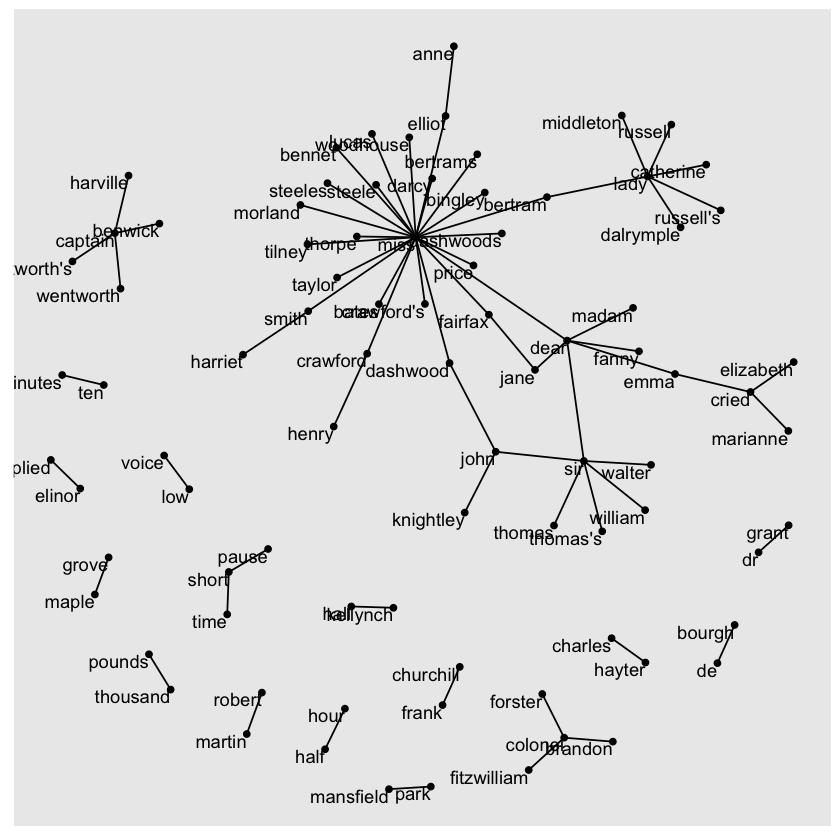

In [ ]:
library(ggraph)

set.seed(2017)

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

The above visualization reveals key aspects of the text’s structure. Salutations like “miss,” “lady,” “sir,” and “colonel” appear as central nodes, frequently connected to names that follow them. Around the edges, we notice common short phrases made up of pairs or triplets of words, such as “half hour,” “thousand pounds,” and “short time/pause.” This network view helps highlight how certain words cluster together in meaningful patterns within the text.


We can also refine the graph’s appearance to enhance readability:

* The `edge\_alpha` aesthetic is added to the links, making connections more transparent when bigrams are less frequent and more opaque when they’re common.
* Directionality is shown with arrows, created using [`grid::arrow()`](https://rdrr.io/r/grid/arrow.html), with an `end\_cap` option to ensure arrows stop just before the nodes for clarity.
* The nodes are styled to be more visually appealing—made larger and colored blue.
* Finally, we apply [`theme\_void()`](https://ggplot2.tidyverse.org/reference/ggtheme.html) to remove background elements and axes, which is ideal for network visualizations.


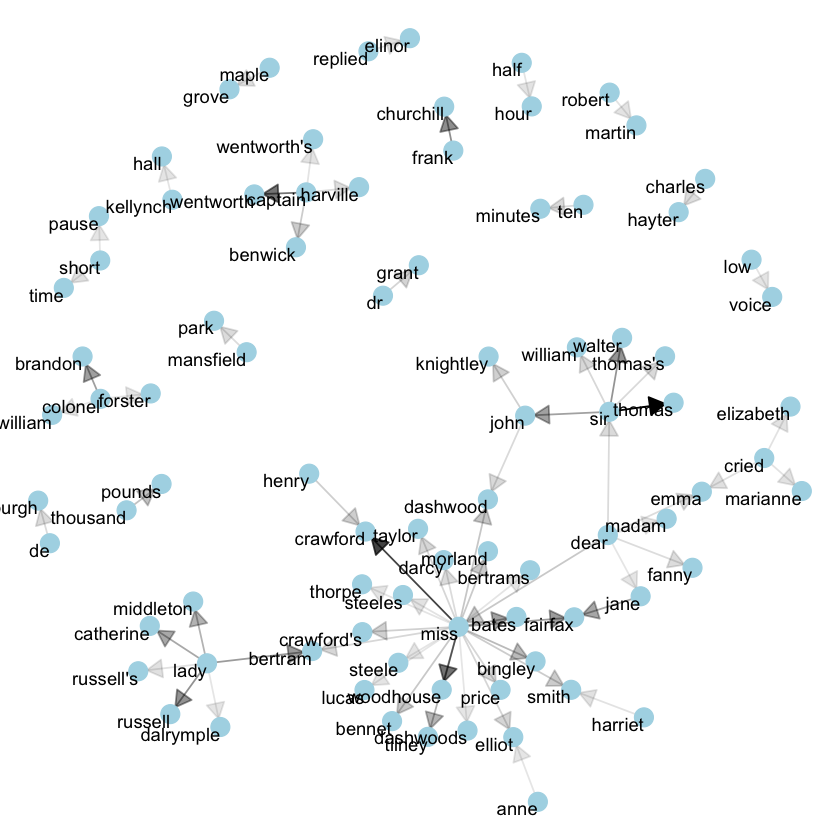

In [60]:
set.seed(2020)

a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(bigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

Getting your networks to look polished with **ggraph** might take some trial and error, but this network structure offers a powerful and flexible way to visualize relationships in tidy data.

Keep in mind, this visualization represents a **Markov chain**, a common model in text analysis where each word depends only on the one before it. For example, a Markov chain-based text generator might start with “dear,” then move to “sir,” followed by “william,” “walter,” or “thomas,” by selecting the most frequent next word at each step.

To keep the graph readable, we only display the most common word-to-word links, but theoretically, you could build a massive graph showing every connection present in the text.

#### Visualizing Bigrams in Other Texts

We put significant effort into cleaning and visualizing bigrams from a text dataset, so now let’s wrap that process into a function. This will allow us to easily apply the same bigram counting and visualization steps to other text datasets.

In [ ]:
library(dplyr)
library(tidyr)
library(tidytext)
library(ggplot2)
library(igraph)
library(ggraph)

count_bigrams <- function(dataset) {
  dataset %>%
    unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
    separate(bigram, c("word1", "word2"), sep = " ") %>%
    filter(!word1 %in% stop_words$word,
           !word2 %in% stop_words$word) %>%
    count(word1, word2, sort = TRUE)
}

visualize_bigrams <- function(bigrams) {
  set.seed(2016)
  a <- grid::arrow(type = "closed", length = unit(.15, "inches"))
  
  bigrams %>%
    graph_from_data_frame() %>%
    ggraph(layout = "fr") +
    geom_edge_link(aes(edge_alpha = n), show.legend = FALSE, arrow = a) +
    geom_node_point(color = "lightblue", size = 5) +
    geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
    theme_void()
}

Now, we can apply our bigram visualization to other texts, like the King James Version of the Bible:

In [ ]:
library(gutenbergr)

# the King James version is book 10 on Project Gutenberg:
kjv <- gutenberg_download(10)

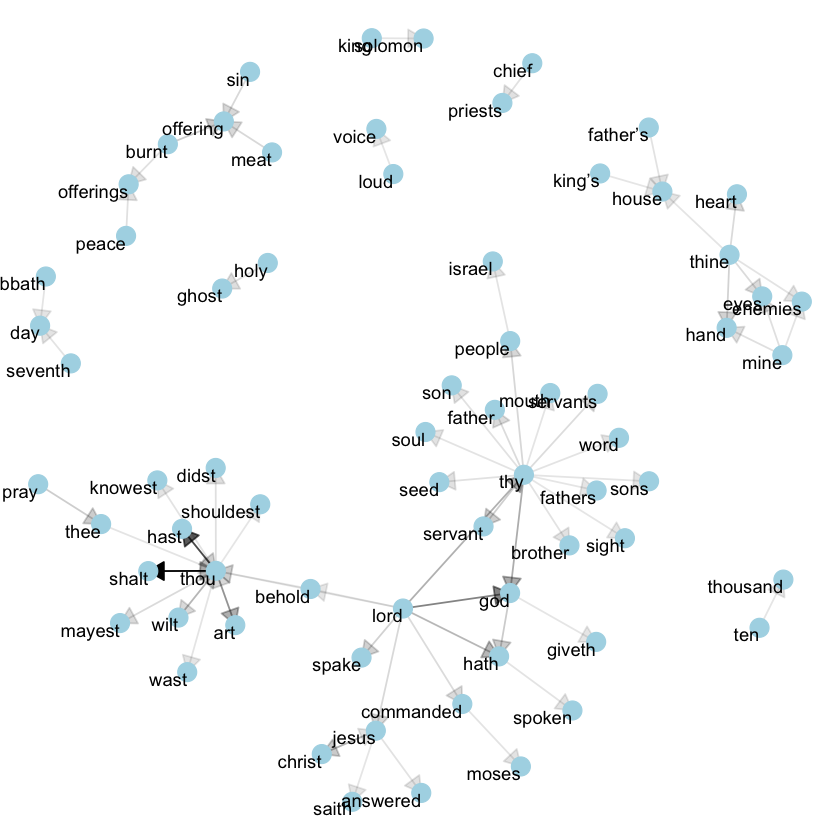

In [ ]:
library(stringr)

kjv_bigrams <- kjv %>%
  count_bigrams()

# filter out rare combinations, as well as digits
kjv_bigrams %>%
  filter(n > 40,
         !str_detect(word1, "\\d"),
         !str_detect(word2, "\\d")) %>%
  visualize_bigrams()

This reveals a typical language pattern in the Bible, especially centered on “thy” and “thou” — words that might well be considered stopwords! Using the gutenbergr package alongside the `count\_bigrams` and `visualize\_bigrams` functions, you can explore and visualize bigrams in other classic texts that interest you.


### Counting and Correlating Pairs of Words with the widyr Package

Tokenizing by n-grams is a helpful approach for examining pairs of adjacent words, but we might also be curious about words that frequently appear together within a document or chapter, even if they aren’t positioned side by side.

While tidy data provides a convenient structure for grouping by rows or comparing variables, comparing between rows — such as counting how often two words appear within the same document or measuring how strongly they are correlated — can be more complex. Typically, to perform pairwise counts or calculate correlations, the data needs to be reshaped into a wide matrix format first.

We’ll explore specific ways to convert tidy text data into wide matrices later, but for this task, that step isn’t required. The **widyr** package simplifies these kinds of operations, allowing us to skip the manual process of widening, analyzing, and then returning to tidy format.

We’ll focus on widyr functions designed for pairwise comparisons — for example, comparing words across different documents or sections of text — making it easy to compute pairwise counts or correlations while keeping the workflow consistent with tidy principles.


#### Counting and Correlating Among Sections

Let’s take the book *Pride and Prejudice* and divide it into sections of 10 lines, similar to how we grouped larger sections for sentiment analysis. This smaller chunk size allows us to analyze word patterns in more detail. Specifically, we can investigate which words frequently appear together within the same 10-line section, providing insight into word relationships beyond immediate adjacency.

In [64]:
austen_section_words <- austen_books() %>%
  filter(book == "Pride & Prejudice") %>%
  mutate(section = row_number() %/% 10) %>%
  filter(section > 0) %>%
  unnest_tokens(word, text) %>%
  filter(!word %in% stop_words$word)

print(austen_section_words)

# A tibble: 37,240 x 3
   book              section word        
   <fct>               <dbl> <chr>       
 1 Pride & Prejudice       1 truth       
 2 Pride & Prejudice       1 universally 
 3 Pride & Prejudice       1 acknowledged
 4 Pride & Prejudice       1 single      
 5 Pride & Prejudice       1 possession  
 6 Pride & Prejudice       1 fortune     
 7 Pride & Prejudice       1 wife        
 8 Pride & Prejudice       1 feelings    
 9 Pride & Prejudice       1 views       
10 Pride & Prejudice       1 entering    
# i 37,230 more rows


The [`pairwise_count()`](https://juliasilge.github.io/widyr/reference/pairwise_count.html) function from the **widyr** package is particularly helpful for this kind of analysis. As the prefix `pairwise\_` suggests, the result will include one row for each unique pair of words from the `word` variable. Using this, we can count how often pairs of words appear together within the same section of text — in this case, within the same 10-line section of *Pride and Prejudice*. This approach gives us insight into word co-occurrence patterns beyond adjacent word pairs like bigrams.

In [ ]:
library(widyr)

# count words co-occuring within sections
word_pairs <- austen_section_words %>%
  pairwise_count(word, section, sort = TRUE)

print(word_pairs)

# A tibble: 796,008 x 3
   item1     item2         n
   <chr>     <chr>     <dbl>
 1 darcy     elizabeth   144
 2 elizabeth darcy       144
 3 miss      elizabeth   110
 4 elizabeth miss        110
 5 elizabeth jane        106
 6 jane      elizabeth   106
 7 miss      darcy        92
 8 darcy     miss         92
 9 elizabeth bingley      91
10 bingley   elizabeth    91
# i 795,998 more rows


Here, the input data originally had one row per word per 10-line section of *Pride and Prejudice*. After using [`pairwise_count()`](https://juliasilge.github.io/widyr/reference/pairwise_count.html), the output reshapes into a tidy format where each row represents a unique pair of words and the number of times they co-occur within the same section.

This structure enables new kinds of analysis, such as determining which words most frequently appear alongside "Darcy." Using simple filtering and sorting, we can quickly extract the top co-occurring words, revealing patterns of association within the text — for instance, showing that "Elizabeth" appears most often with "Darcy," reflecting their central roles in the novel.

In [66]:
word_pairs %>%
  filter(item1 == "darcy") %>%
  print()

# A tibble: 2,930 x 3
   item1 item2         n
   <chr> <chr>     <dbl>
 1 darcy elizabeth   144
 2 darcy miss         92
 3 darcy bingley      86
 4 darcy jane         46
 5 darcy bennet       45
 6 darcy sister       45
 7 darcy time         41
 8 darcy lady         38
 9 darcy friend       37
10 darcy wickham      37
# i 2,920 more rows


#### Pairwise Correlation

Pairs like "Elizabeth" and "Darcy" naturally co-occur frequently, but that alone isn’t very informative since both words are so common in the text individually. Instead of just counting, we can examine *correlation*, which captures how often two words appear together *relative* to how often they appear separately.

One way to measure this is the [phi coefficient](https://en.wikipedia.org/wiki/Phi_coefficient), a standard statistic for binary association. It reflects how much more likely it is that both words appear together (or both are absent) than one appears without the other.

The idea comes from a 2x2 contingency table:

|                | Has word Y | No word Y | Total |
| -------------- | ---------- | --------- | ----- |
| **Has word X** | n₁₁        | n₁₀       | n₁•   |
| **No word X**  | n₀₁        | n₀₀       | n₀•   |
| **Total**      | n•₁        | n•₀       | n     |

* **n₁₁** = sections with both word X and word Y
* **n₀₀** = sections with neither word
* **n₁₀**, **n₀₁** = sections where only one word appears

The phi coefficient is calculated as:

**ϕ = (n₁₁ \* n₀₀ - n₁₀ \* n₀₁) / √(n₁• \* n₀• \* n•₀ \* n•₁)**

This measure is identical to the Pearson correlation when applied to binary (present/absent) data.

The [`pairwise_cor()`](https://juliasilge.github.io/widyr/reference/pairwise_cor.html) function from the **widyr** package computes this for pairs of words, based on how often they co-occur within the same section of text. Its usage is similar to [`pairwise_count()`](https://juliasilge.github.io/widyr/reference/pairwise_count.html), but the output gives correlation values instead of raw counts.


In [67]:
# we need to filter for at least relatively common words first
word_cors <- austen_section_words %>%
  group_by(word) %>%
  filter(n() >= 20) %>%
  pairwise_cor(word, section, sort = TRUE)

print(word_cors)

# A tibble: 154,842 x 3
   item1     item2     correlation
   <chr>     <chr>           <dbl>
 1 bourgh    de              0.951
 2 de        bourgh          0.951
 3 pounds    thousand        0.701
 4 thousand  pounds          0.701
 5 william   sir             0.664
 6 sir       william         0.664
 7 catherine lady            0.663
 8 lady      catherine       0.663
 9 forster   colonel         0.622
10 colonel   forster         0.622
# i 154,832 more rows


This tidy output structure makes it easy to explore word relationships. For instance, you can quickly identify which words are most strongly correlated with a word like **“pounds”** by simply applying a `filter()` to select rows where one of the words is "pounds," then sorting by the correlation strength. This allows you to discover which words frequently appear in the same sections as "pounds," adjusted for how common each word is overall.

In [68]:
word_cors %>%
  filter(item1 == "pounds") %>%
  print()

# A tibble: 393 x 3
   item1  item2     correlation
   <chr>  <chr>           <dbl>
 1 pounds thousand       0.701 
 2 pounds ten            0.231 
 3 pounds fortune        0.164 
 4 pounds settled        0.149 
 5 pounds wickham's      0.142 
 6 pounds children       0.129 
 7 pounds mother's       0.119 
 8 pounds believed       0.0932
 9 pounds estate         0.0890
10 pounds ready          0.0860
# i 383 more rows


This approach allows us to focus on specific words of interest and identify the other words that are most strongly connected or associated with them within the text.

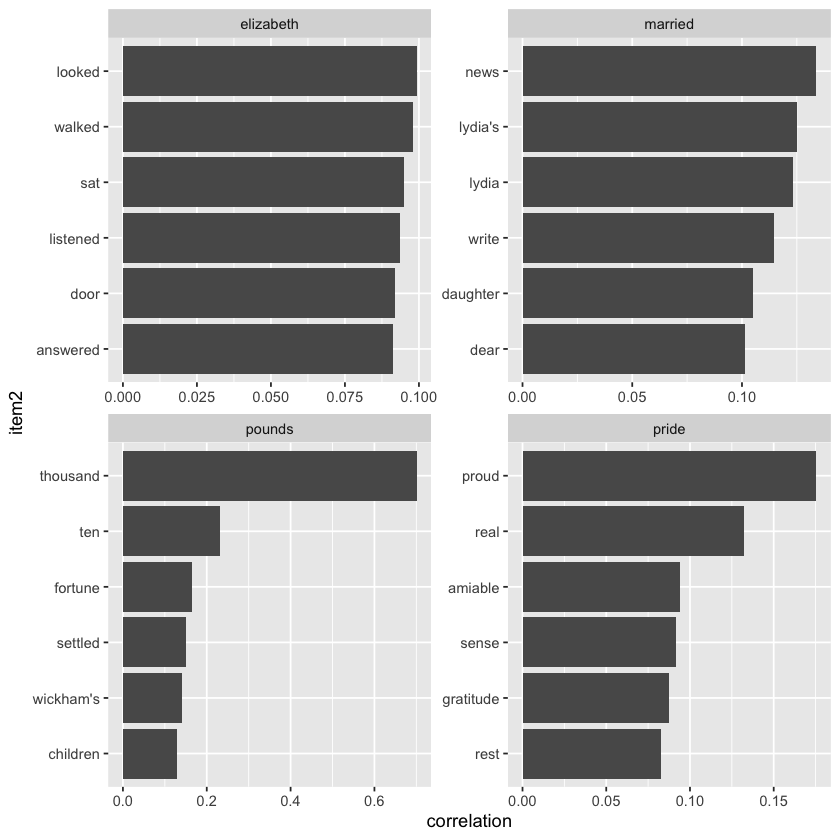

In [69]:
word_cors %>%
  filter(item1 %in% c("elizabeth", "pounds", "married", "pride")) %>%
  group_by(item1) %>%
  slice_max(correlation, n = 6) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ item1, scales = "free") +
  coord_flip()

Similar to how we visualized bigrams using **ggraph**, we can also use it to plot the word correlations and clusters discovered through the **widyr** package. This enables us to clearly see groups of words that tend to appear together in the text.

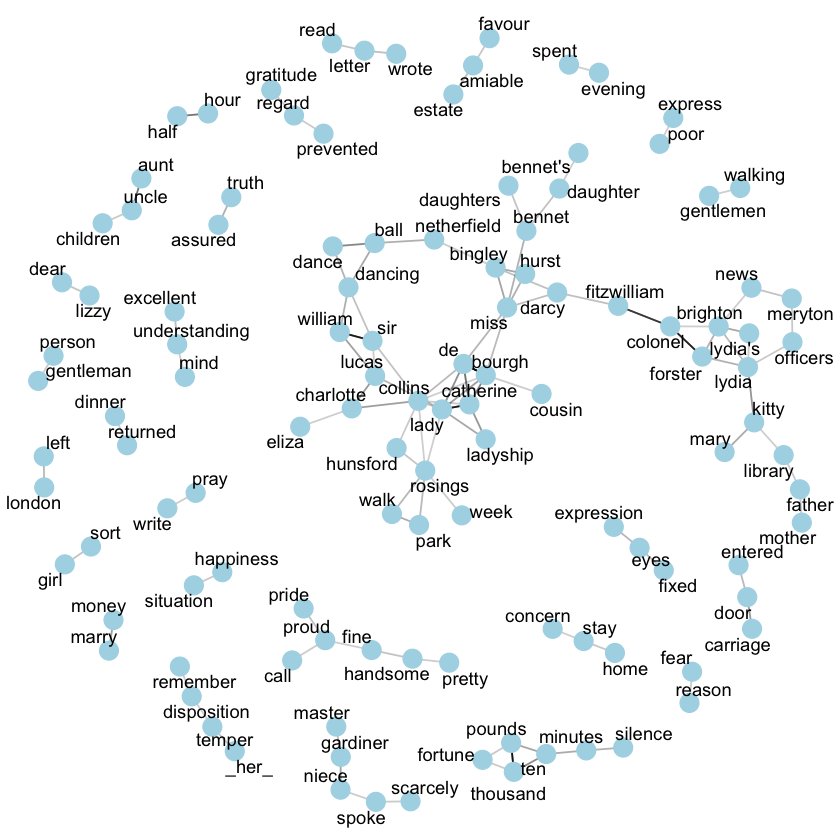

In [70]:
set.seed(2016)

word_cors %>%
  filter(correlation > .15) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = FALSE) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

Unlike the bigram analysis, the word relationships here are **symmetrical**, meaning there is no direction to the connections — so we don’t use arrows. While titles and names like *“colonel/fitzwilliam”* are still common pairings, this method also highlights other word associations that frequently appear near each other, such as *“walk” and “park”* or *“dance” and “ball”*.

## Converting To and From Non-tidy Formats

Above, we analyzed text arranged in the tidy text format: a table with one token per document per row, typically created with the [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) function. This format allows us to use powerful tidy tools like **dplyr**, **tidyr**, and **ggplot2** for exploring and visualizing text data. We have shown that many insightful text analyses can be performed with these tools.

However, most existing R packages for natural language processing—other than **tidytext**—use different input structures and produce outputs that aren’t tidy. The [CRAN Task View for Natural Language Processing](https://cran.r-project.org/web/views/NaturalLanguageProcessing.html) lists many packages that expect non-tidy data formats, which are still very useful for various text mining tasks. 

Computer scientist Hal Abelson once said, “No matter how complex and polished the individual operations are, it is often the quality of the glue that most directly determines the power of the system” [(Abelson 2008)](https://www.tidytextmining.com/references#ref-Friedman:2008:EPL:1378240). In this spirit, this chapter focuses on the “glue” that links the tidy text format with other important packages and data structures, enabling you to combine the strengths of tidy tools with other widely used text mining resources.


### Tidying a Document-term Matrix

A [document-term matrix (DTM)](https://en.wikipedia.org/wiki/Document-term_matrix) is one of the most common data structures used in text mining. In a DTM:

* Each row corresponds to a single document (like a book or article).
* Each column corresponds to a specific term.
* Each cell typically holds the count of how many times that term appears in that document.

Because most document-term pairs do not appear (resulting in many zeros), DTMs are usually stored as sparse matrices. These sparse matrices behave like regular matrices (you can access rows and columns), but they are stored more efficiently. Below, we’ll explore various implementations of sparse matrices.

DTMs can’t be directly used with tidy tools, just as tidy data frames aren’t suitable input for most text mining packages. To bridge this gap, the **tidytext** package provides two key functions:

* `tidy()`: Converts a document-term matrix into a tidy data frame. This function is borrowed from the **broom** package [(Robinson 2017)](https://www.tidytextmining.com/references#ref-R-broom), which tidies many types of statistical objects.
* `cast()`: Converts a tidy data frame (one term per row) back into a matrix. There are three variations:

  * [`cast_sparse()`](https://juliasilge.github.io/tidytext/reference/cast_sparse.html) creates a sparse matrix from the **Matrix** package,
  * [`cast_dtm()](https://juliasilge.github.io/tidytext/reference/document_term_casters.html) creates a **DocumentTermMatrix** object from **tm**,
  * [`cast_dfm()`](https://juliasilge.github.io/tidytext/reference/document_term_casters.html) creates a **dfm** object from **quanteda**.

A DTM corresponds closely to a tidy data frame created by a `count()` or a `group_by()`/`summarize()` operation that tabulates counts or other statistics for each term-document pair.


#### Tidying DocumentTermMatrix Objects

One of the most popular implementations of document-term matrices (DTMs) in R is the **DocumentTermMatrix** class from the **tm** package. Many text mining datasets you’ll encounter come in this format. For example, the **topicmodels** package includes a collection of Associated Press newspaper articles stored as a DocumentTermMatrix.

In [71]:
library(tm)

data("AssociatedPress", package = "topicmodels")
AssociatedPress

Loading required package: NLP


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate




<<DocumentTermMatrix (documents: 2246, terms: 10473)>>
Non-/sparse entries: 302031/23220327
Sparsity           : 99%
Maximal term length: 18
Weighting          : term frequency (tf)

This dataset contains **2,246 documents**, each representing an Associated Press article, and **10,473 distinct terms** (unique words). The matrix is **99% sparse**, meaning that 99% of document-term combinations contain a zero—indicating the term does not appear in that document. You can view the set of terms using the [`Terms()`](https://rdrr.io/cran/tm/man/Docs.html) function.

In [72]:
terms <- Terms(AssociatedPress)
print(head(terms))

[1] "aaron"      "abandon"    "abandoned"  "abandoning" "abbott"    
[6] "abboud"    


To analyze this data using tidy tools, we first need to convert it into a tidy data frame format, with one token per document per row. The `broom` package provides the [`tidy()`](https://generics.r-lib.org/reference/tidy.html) function, which transforms non-tidy objects into tidy data frames. The `tidytext` package extends this functionality to handle `DocumentTermMatrix` objects specifically, allowing us to easily restructure the matrix for use with the tidyverse.

In [73]:
ap_td <- tidy(AssociatedPress)
print(ap_td)

# A tibble: 302,031 x 3
   document term       count
      <int> <chr>      <dbl>
 1        1 adding         1
 2        1 adult          2
 3        1 ago            1
 4        1 alcohol        1
 5        1 allegedly      1
 6        1 allen          1
 7        1 apparently     2
 8        1 appeared       1
 9        1 arrested       1
10        1 assault        1
# i 302,021 more rows


We now have a tidy `tbl_df` with three columns: `document`, `term`, and `count`. This transformation is similar to using [`melt()`](https://rdrr.io/pkg/reshape2/man/melt.html) from the `reshape2` package [(Wickham 2007)](https://www.tidytextmining.com/references#ref-R-reshape2) for standard (non-sparse) matrices.

Importantly, only non-zero values appear in the tidy output — for instance, document 1 contains terms like “adding” and “adult,” but terms such as “aaron” or “abandon” are excluded because they don’t occur in that document. As with earlier examples, this tidy structure works well for analysis using `dplyr`, `tidytext`, and `ggplot2`. You could now apply familiar techniques like sentiment analysis to these newspaper articles.

In [74]:
ap_sentiments <- ap_td %>%
  inner_join(get_sentiments("bing"), by = c(term = "word"))

print(ap_sentiments)

# A tibble: 30,094 x 4
   document term    count sentiment
      <int> <chr>   <dbl> <chr>    
 1        1 assault     1 negative 
 2        1 complex     1 negative 
 3        1 death       1 negative 
 4        1 died        1 negative 
 5        1 good        2 positive 
 6        1 illness     1 negative 
 7        1 killed      2 negative 
 8        1 like        2 positive 
 9        1 liked       1 positive 
10        1 miracle     1 positive 
# i 30,084 more rows


This approach allows us to visualize which words from the AP articles contributed most frequently to positive or negative sentiment. Common positive words include “like,” “work,” “support,” and “good,” while words like “killed,” “death,” and “vice” appear most often on the negative side. It’s worth noting that the word “vice” being flagged as negative is probably a misclassification by the algorithm — in most cases, it likely refers to “vice president” rather than carrying a negative connotation.

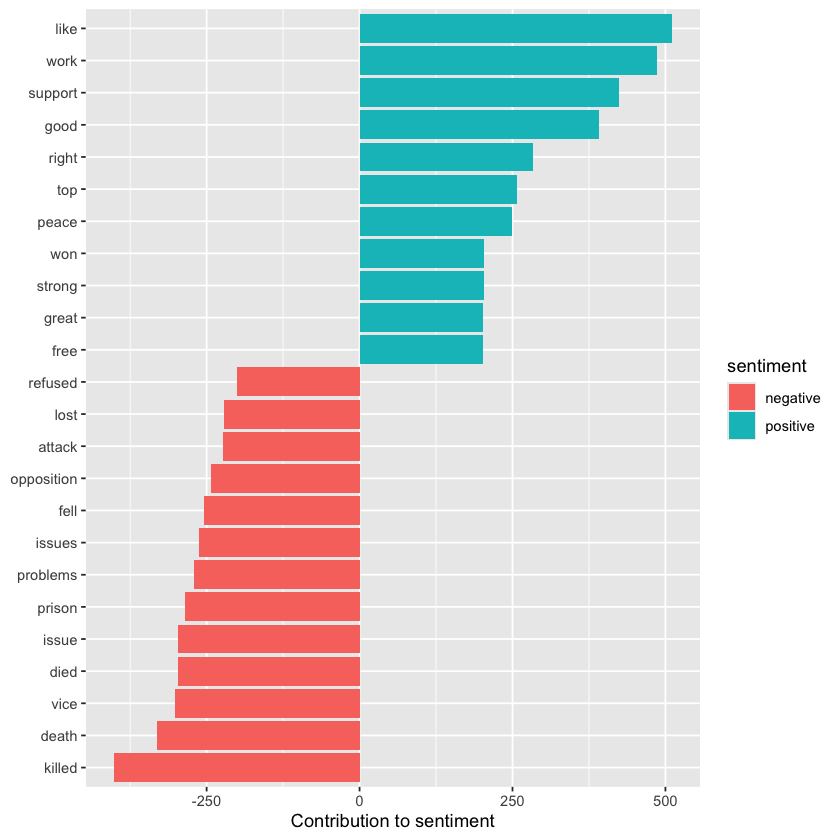

In [ ]:
library(ggplot2)

ap_sentiments %>%
  count(sentiment, term, wt = count) %>%
  filter(n >= 200) %>%
  mutate(n = ifelse(sentiment == "negative", -n, n)) %>%
  mutate(term = reorder(term, n)) %>%
  ggplot(aes(n, term, fill = sentiment)) +
  geom_col() +
  labs(x = "Contribution to sentiment", y = NULL) 

#### Tidying dfm Objects

Other text mining packages offer different formats for document-term matrices, such as the *dfm* (document-feature matrix) from the **quanteda** package [(Benoit and Nulty, 2016)](https://www.tidytextmining.com/references#ref-R-quanteda). For instance, **quanteda** includes a built-in corpus of U.S. presidential inauguration speeches, which can be easily transformed into a dfm using the package's functions.

In [76]:
data("data_corpus_inaugural", package = "quanteda")
inaug_dfm <- data_corpus_inaugural %>%
  quanteda::tokens() %>%
  quanteda::dfm(verbose = FALSE)
print(inaug_dfm)

Warning message in (function (n) :
"strings not representable in native encoding will be translated to UTF-8"


Document-feature matrix of: 60 documents, 9,437 features (91.84% sparse) and 4 docvars.
                 features
docs              fellow-citizens  of the senate and house representatives :
  1789-Washington               1  71 116      1  48     2               2 1
  1793-Washington               0  11  13      0   2     0               0 1
  1797-Adams                    3 140 163      1 130     0               2 0
  1801-Jefferson                2 104 130      0  81     0               0 1
  1805-Jefferson                0 101 143      0  93     0               0 0
  1809-Madison                  1  69 104      0  43     0               0 0
                 features
docs              among vicissitudes
  1789-Washington     1            1
  1793-Washington     0            0
  1797-Adams          4            0
  1801-Jefferson      1            0
  1805-Jefferson      7            0
  1809-Madison        0            0
[ reached max_ndoc ... 54 more documents, reached max_nfeat ..

The `tidy()` function also works on these document-feature matrices, converting them into a tidy table where each row represents one token for each document.

In [77]:
inaug_td <- tidy(inaug_dfm)
print(inaug_td)

# A tibble: 46,196 x 3
   document        term            count
   <chr>           <chr>           <dbl>
 1 1789-Washington fellow-citizens     1
 2 1797-Adams      fellow-citizens     3
 3 1801-Jefferson  fellow-citizens     2
 4 1809-Madison    fellow-citizens     1
 5 1813-Madison    fellow-citizens     1
 6 1817-Monroe     fellow-citizens     5
 7 1821-Monroe     fellow-citizens     1
 8 1841-Harrison   fellow-citizens    11
 9 1845-Polk       fellow-citizens     1
10 1849-Taylor     fellow-citizens     1
# i 46,186 more rows


To identify the words most specific to each inaugural speech, we can calculate the tf-idf for each term-speech pair using the [`bind_tf_idf()`](https://juliasilge.github.io/tidytext/reference/bind_tf_idf.html) function.


In [78]:
inaug_tf_idf <- inaug_td %>%
  bind_tf_idf(term, document, count) %>%
  arrange(desc(tf_idf))

print(inaug_tf_idf)

# A tibble: 46,196 x 6
   document        term        count      tf   idf tf_idf
   <chr>           <chr>       <dbl>   <dbl> <dbl>  <dbl>
 1 1793-Washington arrive          1 0.00680  4.09 0.0279
 2 1793-Washington upbraidings     1 0.00680  4.09 0.0279
 3 1793-Washington violated        1 0.00680  3.40 0.0231
 4 1793-Washington willingly       1 0.00680  3.40 0.0231
 5 1793-Washington incurring       1 0.00680  3.40 0.0231
 6 1793-Washington previous        1 0.00680  3.00 0.0204
 7 1793-Washington knowingly       1 0.00680  3.00 0.0204
 8 1793-Washington injunctions     1 0.00680  3.00 0.0204
 9 1793-Washington witnesses       1 0.00680  3.00 0.0204
10 1793-Washington besides         1 0.00680  2.71 0.0184
# i 46,186 more rows


This data allows us to select four significant inaugural speeches—by Presidents Lincoln, Roosevelt, Kennedy, and Obama—and visualize the words with the highest tf-idf scores for each, highlighting the terms most characteristic of each speech.

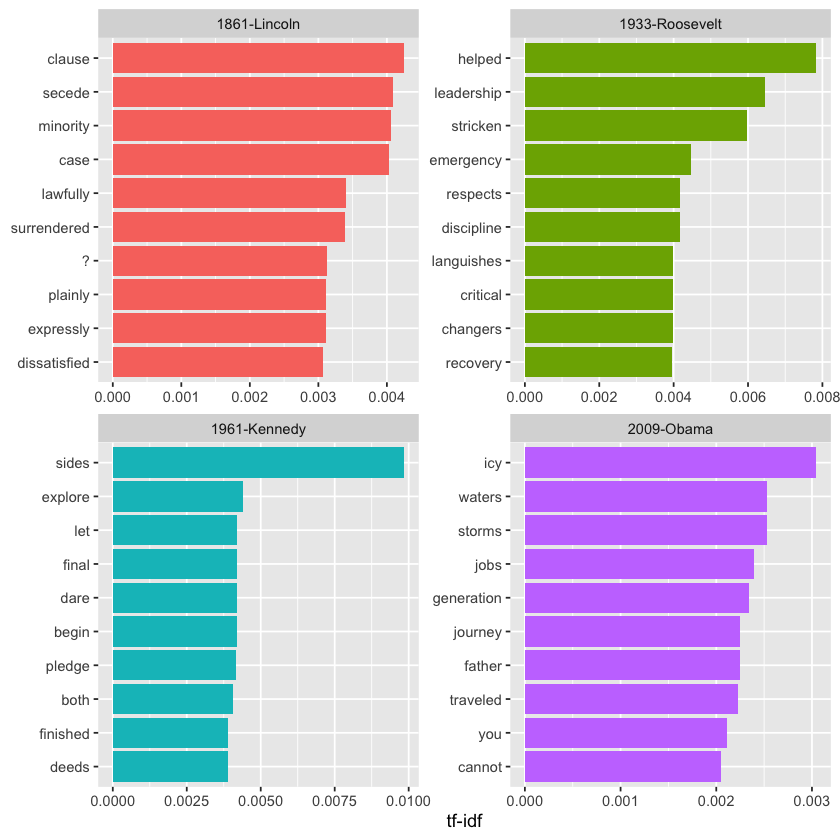

In [79]:
speeches <- c("1933-Roosevelt", "1861-Lincoln",
              "1961-Kennedy", "2009-Obama")

inaug_tf_idf %>%
  filter(document %in% speeches) %>%
  group_by(document) %>%
  slice_max(tf_idf, n = 10, with_ties = FALSE) %>%
  ungroup() %>%
  mutate(term = reorder_within(term, tf_idf, document)) %>%
  ggplot(aes(term, tf_idf, fill = document)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ document, scales = "free") +
  coord_flip() +
  scale_x_reordered() +
  labs(x = NULL,
       y = "tf-idf")

Here’s another example of a visualization enabled by tidy data: we can extract the year from each document’s title and calculate the total word count for each year.

Note that we use tidyr’s [`complete()`](https://tidyr.tidyverse.org/reference/complete.html) function to fill in zeros for any years where a particular word does not appear, ensuring the table is complete.


In [ ]:
library(tidyr)

year_term_counts <- inaug_td %>%
  extract(document, "year", "(\\d+)", convert = TRUE) %>%
  complete(year, term, fill = list(count = 0)) %>%
  group_by(year) %>%
  mutate(year_total = sum(count))

This allows us to select several words and visualize how their frequencies have changed over time. We observe that, over time, American presidents increasingly favored the term “America” over “Union.” Additionally, references to the “constitution” and “foreign” countries declined, while mentions of “freedom” and “God” became more common.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


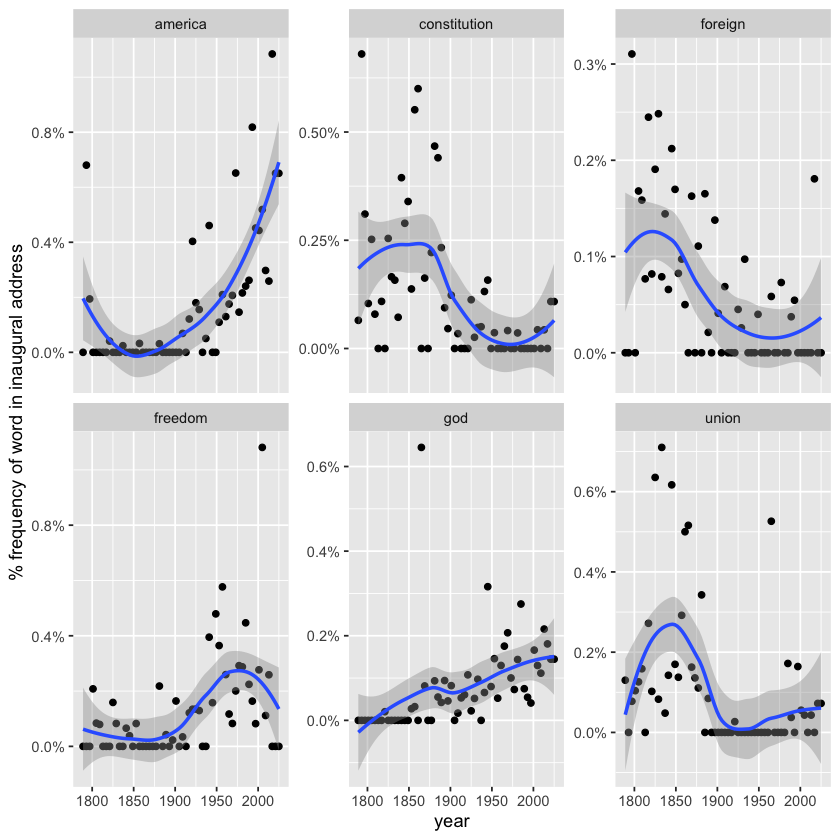

In [81]:
year_term_counts %>%
  filter(term %in% c("god", "america", "foreign", "union", "constitution", "freedom")) %>%
  ggplot(aes(year, count / year_total)) +
  geom_point() +
  geom_smooth() +
  facet_wrap(~ term, scales = "free_y") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(y = "% frequency of word in inaugural address")

These examples demonstrate how tidytext, along with its ecosystem of tidy tools, enables you to analyze texts effectively—even when the original data isn’t in a tidy format.

### Casting Tidy Text Data Into a Matrix

Just as some text mining packages offer document-term matrices as sample data or output, certain algorithms require these matrices as input. To accommodate this, tidytext provides `cast\_` functions that convert tidy data back into such matrix formats.

For instance, we can convert the tidied AP dataset back into a document-term matrix using the [`cast\_dtm()`](https://juliasilge.github.io/tidytext/reference/document_term_casters.html) function.

In [82]:
ap_td %>%
  cast_dtm(document, term, count)

<<DocumentTermMatrix (documents: 2246, terms: 10473)>>
Non-/sparse entries: 302031/23220327
Sparsity           : 99%
Maximal term length: 18
Weighting          : term frequency (tf)

Similarly, we can convert the table into a dfm object from the quanteda package using the [`cast\_dfm()`](https://juliasilge.github.io/tidytext/reference/document_term_casters.html) function.

In [83]:
ap_td %>%
  cast_dfm(document, term, count)

Document-feature matrix of: 2,246 documents, 10,473 features (98.72% sparse) and 0 docvars.
    features
docs adding adult ago alcohol allegedly allen apparently appeared arrested
   1      1     2   1       1         1     1          2        1        1
   2      0     0   0       0         0     0          0        1        0
   3      0     0   1       0         0     0          0        1        0
   4      0     0   3       0         0     0          0        0        0
   5      0     0   0       0         0     0          0        0        0
   6      0     0   2       0         0     0          0        0        0
    features
docs assault
   1       1
   2       0
   3       0
   4       0
   5       0
   6       0
[ reached max_ndoc ... 2,240 more documents, reached max_nfeat ... 10,463 more features ]

Some tools simply require a sparse matrix:

In [ ]:
library(Matrix)

# cast into a Matrix object
m <- ap_td %>%
  cast_sparse(document, term, count)

class(m)

dim(m)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

[1]  2246 10473

This type of conversion can be easily performed on any tidy text data we've worked with throughout this book. For instance, creating a document-term matrix (DTM) of Jane Austen’s novels can be done in just a few lines of code.

In [ ]:
library(janeaustenr)

austen_dtm <- austen_books() %>%
  unnest_tokens(word, text) %>%
  count(book, word) %>%
  cast_dtm(book, word, n)

austen_dtm

<<DocumentTermMatrix (documents: 6, terms: 14516)>>
Non-/sparse entries: 40378/46718
Sparsity           : 54%
Maximal term length: 19
Weighting          : term frequency (tf)

This casting process enables you to perform reading, filtering, and manipulation with dplyr and other tidy tools, and then convert the resulting data into a document-term matrix suitable for machine learning tasks. In Chapter 6, we will explore examples where tidy-text datasets are transformed into DocumentTermMatrix objects for further analysis and modeling.

### Tidying Corpus Objects with Metadata

Some data structures are specifically designed to hold collections of documents prior to tokenization and are often referred to as a “corpus.” A common example in R is the **Corpus** object from the **tm** package. These objects store the raw text along with associated metadata such as document IDs, timestamps, titles, or language information for each document.

For instance, the **tm** package includes the **acq** corpus, which contains 50 news articles from the Reuters news service.


In [86]:
data("acq")
acq

# first document
acq[[1]]

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 50

<<PlainTextDocument>>
Metadata:  15
Content:  chars: 1287

A corpus object is organized like a list, where each element holds both the text and its metadata (for more details, see the tm package documentation on working with Corpus objects). While this structure is flexible for storing documents, it is not directly compatible with tidy tools for analysis.

To bridge this gap, we can apply the [`tidy()`](https://generics.r-lib.org/reference/tidy.html) method, which converts the corpus into a table format with one row per document. This table includes metadata columns—such as document ID and timestamp—alongside the corresponding text, making it much easier to work with using tidyverse tools.

In [87]:
acq_td <- tidy(acq)
print(acq_td)

# A tibble: 50 x 16
   author   datetimestamp       description heading id    language origin topics
   <chr>    <dttm>              <chr>       <chr>   <chr> <chr>    <chr>  <chr> 
 1 NA       1987-02-26 15:18:06 ""          COMPUT~ 10    en       Reute~ YES   
 2 NA       1987-02-26 15:19:15 ""          OHIO M~ 12    en       Reute~ YES   
 3 NA       1987-02-26 15:49:56 ""          MCLEAN~ 44    en       Reute~ YES   
 4 By Cal ~ 1987-02-26 15:51:17 ""          CHEMLA~ 45    en       Reute~ YES   
 5 NA       1987-02-26 16:08:33 ""          <COFAB~ 68    en       Reute~ YES   
 6 NA       1987-02-26 16:32:37 ""          INVEST~ 96    en       Reute~ YES   
 7 By Patt~ 1987-02-26 16:43:13 ""          AMERIC~ 110   en       Reute~ YES   
 8 NA       1987-02-26 16:59:25 ""          HONG K~ 125   en       Reute~ YES   
 9 NA       1987-02-26 17:01:28 ""          LIEBER~ 128   en       Reute~ YES   
10 NA       1987-02-26 17:08:27 ""          GULF A~ 134   en       Reute~ YES   
# i 40 m

Once converted into this tidy table format, you can apply [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to break the text into individual tokens (like words). This allows you to perform analyses such as identifying the most frequent words across all 50 Reuters articles or finding words that are particularly distinctive to each article.

In [88]:
acq_tokens <- acq_td %>%
  select(-places) %>%
  unnest_tokens(word, text) %>%
  anti_join(stop_words, by = "word")

# most common words
acq_tokens %>%
  count(word, sort = TRUE) %>%
  print()

# tf-idf
acq_tokens %>%
  count(id, word) %>%
  bind_tf_idf(word, id, n) %>%
  arrange(desc(tf_idf)) %>%
  print()

# A tibble: 1,559 x 2
   word         n
   <chr>    <int>
 1 dlrs       100
 2 pct         70
 3 mln         65
 4 company     63
 5 shares      52
 6 reuter      50
 7 stock       46
 8 offer       34
 9 share       34
10 american    28
# i 1,549 more rows
# A tibble: 2,833 x 6
   id    word         n     tf   idf tf_idf
   <chr> <chr>    <int>  <dbl> <dbl>  <dbl>
 1 186   groupe       2 0.133   3.91  0.522
 2 128   liebert      3 0.130   3.91  0.510
 3 474   esselte      5 0.114   3.91  0.445
 4 371   burdett      6 0.103   3.91  0.405
 5 442   hazleton     4 0.103   3.91  0.401
 6 199   circuit      5 0.102   3.91  0.399
 7 441   rmj          8 0.123   3.22  0.396
 8 162   suffield     2 0.1     3.91  0.391
 9 498   west         3 0.1     3.91  0.391
10 467   nursery      3 0.0968  3.91  0.379
# i 2,823 more rows


## Topic Modeling

In text mining, we often work with collections of documents, like news articles or blog posts, that we want to separate into meaningful groups to better analyze them. Topic modeling provides a way to automatically classify these documents without supervision, much like clustering with numerical data, helping reveal natural groupings even if we don’t know what to expect.

Latent Dirichlet Allocation (LDA) is one of the most widely used techniques for building a topic model. It represents each document as a blend of multiple topics and each topic as a mixture of words. This approach allows documents to share content across topics, rather than being divided into distinct, rigid categories, reflecting how language typically functions.

Tidy text principles let us apply the same tidy tools we’ve used throughout this book to topic modeling tasks. In this chapter, we’ll focus on working with LDA models from the [topicmodels package](https://cran.r-project.org/web/packages/topicmodels/index.html), particularly tidying them so they integrate smoothly with ggplot2 and dplyr. We’ll also walk through an example of clustering chapters from different books, where we’ll see how a topic model can “learn” to distinguish among the four books based on their textual content.


### Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is one of the most widely used algorithms for topic modeling. Without getting into the mathematical details, we can understand LDA through two core ideas.

Each document is made up of a combination of topics. We assume that every document contains words from several topics, each appearing in specific proportions. For instance, with a two-topic model, we might say, “Document 1 consists of 90% Topic A and 10% Topic B, while Document 2 contains 30% Topic A and 70% Topic B.”

Each topic is made up of a mixture of words. For example, imagine a two-topic model focused on U.S. news, with one topic representing “politics” and another representing “entertainment.” The politics topic might include words like “President,” “Congress,” and “government,” while the entertainment topic might include terms such as “movies,” “television,” and “actor.” It’s also important to note that some words can appear in both topics; for example, the word “budget” might be relevant to both.

LDA is a statistical approach that estimates these relationships simultaneously: determining the mixture of words associated with each topic, while also identifying the mixture of topics present within each document. Several software implementations of this technique exist, and we’ll take a closer look at one of them.

Above, we briefly discussed the `AssociatedPress` dataset included with the topicmodels package, which serves as an example of a Document-Term Matrix. This dataset contains 2,246 news articles from an American news organization, mostly dating from around 1988.



In [89]:
library(topicmodels)

data("AssociatedPress")
AssociatedPress

<<DocumentTermMatrix (documents: 2246, terms: 10473)>>
Non-/sparse entries: 302031/23220327
Sparsity           : 99%
Maximal term length: 18
Weighting          : term frequency (tf)

We can apply the [`LDA()`](https://rdrr.io/cran/topicmodels/man/lda.html) function from the **topicmodels** package, specifying `k = 2`, to build a two-topic LDA model.

In most real-world applications, topic models typically use a larger value of `k`, but as we’ll see, the same analysis process applies when working with more topics.

This function returns an object that holds all the details of the fitted model, including the relationships between words and topics, as well as between topics and documents.


In [90]:
# set a seed so that the output of the model is predictable
ap_lda <- LDA(AssociatedPress, k = 2, control = list(seed = 1234))
ap_lda

A LDA_VEM topic model with 2 topics.

Fitting the model was the straightforward step; the real work lies in exploring and interpreting it using tidying functions from the tidytext package.

#### Word-topic Probabilities

Above we introduced the [`tidy()`](https://generics.r-lib.org/reference/tidy.html) method, originally from the broom package [(Robinson 2017)](https://www.tidytextmining.com/references#ref-R-broom), for tidying model objects. The tidytext package provides this method for extracting the per-topic-per-word probabilities, called β (“beta”), from the model.

In [91]:
library(tidytext)

ap_topics <- tidy(ap_lda, matrix = "beta")
print(ap_topics)

# A tibble: 20,946 x 3
   topic term           beta
   <int> <chr>         <dbl>
 1     1 aaron      1.69e-12
 2     2 aaron      3.90e- 5
 3     1 abandon    2.65e- 5
 4     2 abandon    3.99e- 5
 5     1 abandoned  1.39e- 4
 6     2 abandoned  5.88e- 5
 7     1 abandoning 2.45e-33
 8     2 abandoning 2.34e- 5
 9     1 abbott     2.13e- 6
10     2 abbott     2.97e- 5
# i 20,936 more rows


Notice that this transforms the model into a format with one topic-term pair per row. For each pair, the model calculates the probability that the term is generated by that topic. For example, the term “aaron” has a probability of $1.686917 \times 10^{-12}$ of being generated by topic 1, but a probability of
$3.8959408 \times 10^{-5}$ of coming from topic 2.

We can use dplyr’s [`slice_max()`](https://dplyr.tidyverse.org/reference/slice.html) to identify the top 10 terms most strongly associated with each topic. As a tidy data frame, this structure is well suited for visualization using ggplot2.


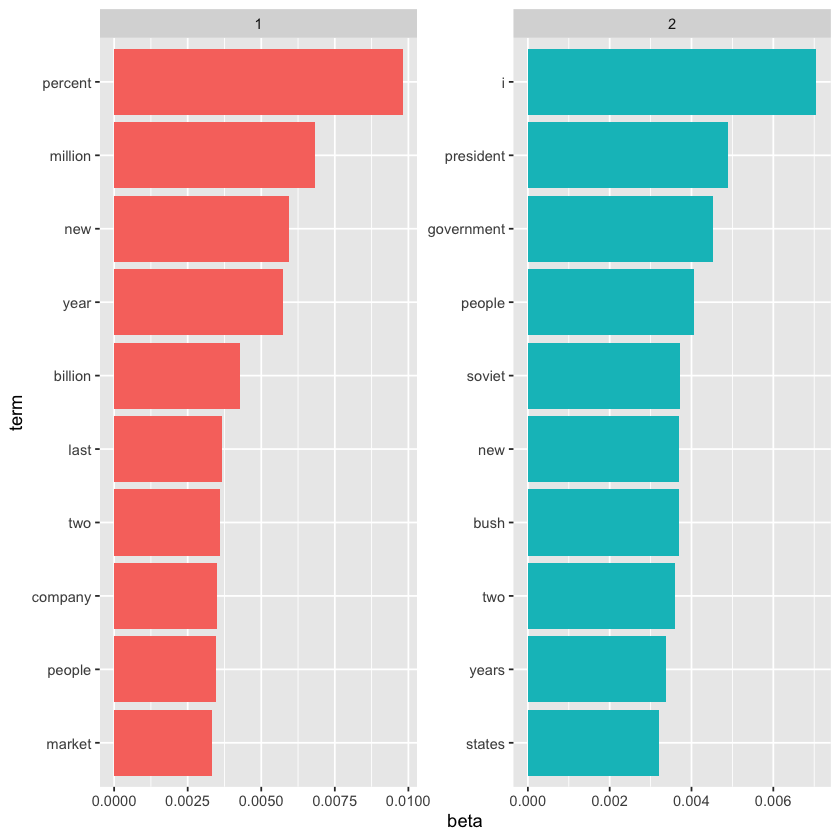

In [92]:
library(ggplot2)
library(dplyr)

ap_top_terms <- ap_topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

This visualization helps us interpret the two topics extracted from the articles. The most frequent words in topic 1 include “percent,” “million,” “billion,” and “company,” indicating it likely relates to business or financial news. In contrast, topic 2 features common words like “president,” “government,” and “soviet,” suggesting it represents political news. Notably, some words such as “new” and “people” appear frequently in both topics. This overlap is a key advantage of topic modeling compared to “hard clustering” methods, as topics in natural language often share vocabulary.

Alternatively, we can focus on terms with the largest difference in $\beta$ between topic 1 and topic 2. This difference can be measured using the log ratio:
$\log_2(\frac{\beta_2}{\beta_1})$ (log ratios are helpful because they create symmetry — if $\beta_2$ is twice $\beta_1$, the ratio is 1; if $\beta_1$ is twice $\beta_2$, it’s -1). To focus on especially relevant words, we can filter for terms with $\beta$ values greater than 1/1000 in at least one topic.


In [93]:
library(tidyr)

beta_wide <- ap_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  pivot_wider(names_from = topic, values_from = beta) %>% 
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

print(beta_wide)

# A tibble: 198 x 4
   term              topic1      topic2 log_ratio
   <chr>              <dbl>       <dbl>     <dbl>
 1 administration 0.000431  0.00138         1.68 
 2 ago            0.00107   0.000842       -0.339
 3 agreement      0.000671  0.00104         0.630
 4 aid            0.0000476 0.00105         4.46 
 5 air            0.00214   0.000297       -2.85 
 6 american       0.00203   0.00168        -0.270
 7 analysts       0.00109   0.000000578   -10.9  
 8 area           0.00137   0.000231       -2.57 
 9 army           0.000262  0.00105         2.00 
10 asked          0.000189  0.00156         3.05 
# i 188 more rows


The words with the greatest differences between the two topics are visualized below.

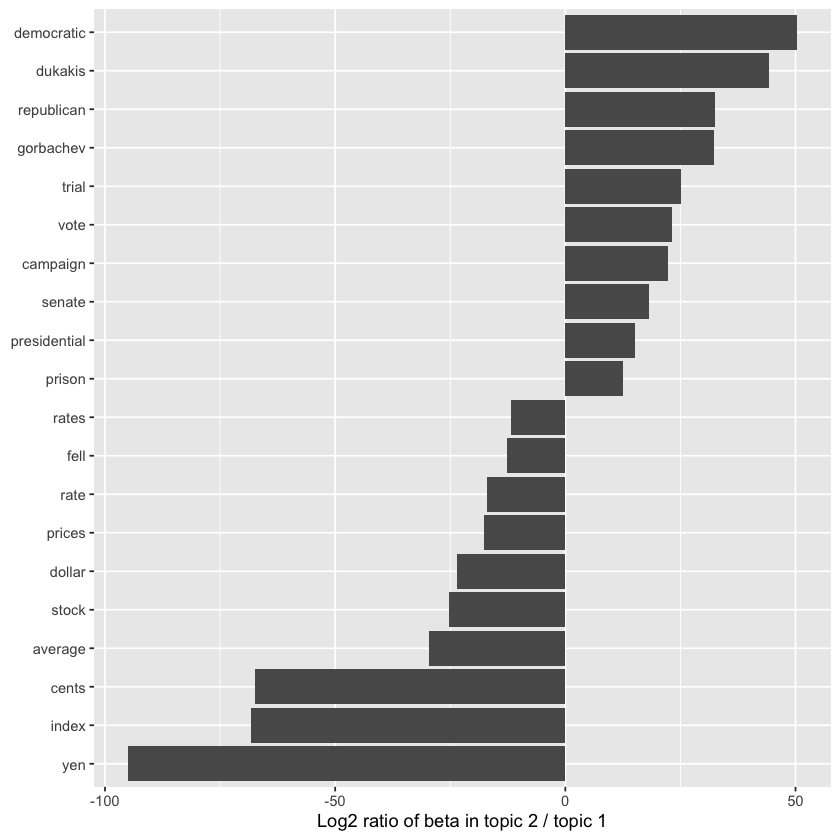

In [94]:
beta_wide %>%
  group_by(direction = log_ratio > 0) %>%
  slice_max(abs(log_ratio), n = 10) %>% 
  ungroup() %>%
  mutate(term = reorder(term, log_ratio)) %>%
  ggplot(aes(log_ratio, term)) +
  geom_col() +
  labs(x = "Log2 ratio of beta in topic 2 / topic 1", y = NULL)

We observe that words more prevalent in topic 2 include political parties like “democratic” and “republican,” along with politicians’ names such as “dukakis” and “gorbachev.” Topic 1, on the other hand, is distinguished by currency terms like “yen” and “dollar,” as well as financial words such as “index,” “prices,” and “rates.” This supports the conclusion that the two topics identified by the algorithm correspond to political and financial news.


#### Document-topic Probabilities

In addition to representing each topic as a mixture of words, LDA also models each document as a mixture of topics. We can explore the per-document-per-topic probabilities, known as $\gamma$ (“gamma”), by using the `matrix = "gamma"` argument with the [`tidy()`](https://generics.r-lib.org/reference/tidy.html) function.


In [95]:
ap_documents <- tidy(ap_lda, matrix = "gamma")
print(ap_documents)

# A tibble: 4,492 x 3
   document topic    gamma
      <int> <int>    <dbl>
 1        1     1 0.248   
 2        2     1 0.362   
 3        3     1 0.527   
 4        4     1 0.357   
 5        5     1 0.181   
 6        6     1 0.000588
 7        7     1 0.773   
 8        8     1 0.00445 
 9        9     1 0.967   
10       10     1 0.147   
# i 4,482 more rows


Each value represents the estimated proportion of words in a document generated by a specific topic. For instance, the model estimates that about 25% of the words in document 1 come from topic 1.

We can observe that many documents contain a mixture of both topics, while document 6 is almost entirely from topic 2, with a $\gamma$ value for topic 1 near zero. To verify this, we could [`tidy()`](https://generics.r-lib.org/reference/tidy.html) the document-term matrix and examine the most frequent words in that document.


In [96]:
tidy(AssociatedPress) %>%
  filter(document == 6) %>%
  arrange(desc(count)) %>%
  print()

# A tibble: 287 x 3
   document term           count
      <int> <chr>          <dbl>
 1        6 noriega           16
 2        6 panama            12
 3        6 jackson            6
 4        6 powell             6
 5        6 administration     5
 6        6 economic           5
 7        6 general            5
 8        6 i                  5
 9        6 panamanian         5
10        6 american           4
# i 277 more rows


Judging by the most frequent words, this article seems to discuss the relationship between the American government and Panamanian dictator Manuel Noriega, confirming that the algorithm correctly assigned it to topic 2 (political/national news).

###  Example: The Great Library Heist

When testing a statistical method, it’s helpful to apply it to a simple case where the “correct answer” is known. For example, we could gather a set of documents clearly related to four distinct topics, then use topic modeling to see if the algorithm correctly separates these groups. This allows us to verify the method’s effectiveness and understand its limitations. We’ll explore this using classic literature.

Imagine a vandal broke into your study and tore apart four books:

* *Great Expectations* by Charles Dickens
* *The War of the Worlds* by H.G. Wells
* *Twenty Thousand Leagues Under the Sea* by Jules Verne
* *Pride and Prejudice* by Jane Austen

The vandal has shredded the books into individual chapters and dumped them all together in a pile. How can we put the chapters back in order by their original books? This is a difficult task because the chapters are unlabeled—we don’t know which words will differentiate the groups. We’ll use topic modeling to uncover how the chapters cluster into distinct topics, each presumably corresponding to one of the four books.

To do this, we’ll retrieve the texts of these books using the **gutenbergr** package introduced earlier.


In [129]:
titles <- c("Twenty Thousand Leagues under the Sea", 
            "The War of the Worlds",
            "Pride and Prejudice", 
            "Great Expectations")

In [130]:
library(gutenbergr)

books <- gutenberg_works(title %in% titles) %>%
  gutenberg_download(meta_fields = "title")

For pre-processing, we split the texts into chapters, then use tidytext’s [`unnest_tokens()`](https://juliasilge.github.io/tidytext/reference/unnest_tokens.html) to break them down into individual words, followed by removing stop words. Each chapter is treated as its own “document,” labeled with names like `Great Expectations\_1` or `Pride and Prejudice\_11`. (In other contexts, a document might be a single news article or blog post.)

In [138]:
# Check what lines contain potential chapter markers
books %>% 
  filter(str_detect(text, regex("^(chapter|[ivxlcdm]+)", ignore_case = TRUE))) %>%
  select(title, text) %>%
  head(50)

title,text
<chr>,<chr>
The War of the Worlds,cover
The War of the Worlds,Contents
The War of the Worlds,I.
The War of the Worlds,disillusionment.
The War of the Worlds,"must be, if the nebular hypothesis has any truth, older than our world;"
The War of the Worlds,must have begun its course. The fact that it is scarcely one seventh of
The War of the Worlds,"intelligent life might have developed there far, or indeed at all,"
The War of the Worlds,"Mars is older than our earth, with scarcely a quarter of the"
The War of the Worlds,it is not only more distant from time<U+2019>s beginning but nearer its end.


In [139]:
library(stringr)

# divide into documents, each representing one chapter
by_chapter <- books %>%
  group_by(title) %>%
  mutate(chapter = cumsum(str_detect(
    text, regex("^(chapter\\s|^[ivxlc]+\\.$)", ignore_case = TRUE)
  ))) %>%
  ungroup() %>%
  filter(chapter > 0) %>%
  unite(document, title, chapter)

# split into words
by_chapter_word <- by_chapter %>%
  unnest_tokens(word, text)

# find document-word counts
word_counts <- by_chapter_word %>%
  anti_join(stop_words) %>%
  count(document, word, sort = TRUE)

print(word_counts)

Joining with `by = join_by(word)`


# A tibble: 106,659 x 3
   document                 word        n
   <chr>                    <chr>   <int>
 1 Great Expectations_59    joe        88
 2 Great Expectations_7     joe        70
 3 Great Expectations_17    biddy      63
 4 Great Expectations_27    joe        58
 5 Great Expectations_38    estella    58
 6 Great Expectations_2     joe        56
 7 Great Expectations_23    pocket     53
 8 Great Expectations_15    joe        50
 9 Great Expectations_18    joe        50
10 The War of the Worlds_16 brother    50
# i 106,649 more rows


#### LDA on Chapters

Currently, our data frame `word_counts` is in tidy format, with one term per document per row. However, the **topicmodels** package expects a `DocumentTermMatrix`. We can convert a one-token-per-row table into a `DocumentTermMatrix` using tidytext’s [`cast_dtm()`](https://juliasilge.github.io/tidytext/reference/document_term_casters.html) function.

In [132]:
chapters_dtm <- word_counts %>%
  cast_dtm(document, word, n)

print(chapters_dtm)

<<DocumentTermMatrix (documents: 196, terms: 18393)>>
Non-/sparse entries: 106743/3498285
Sparsity           : 97%
Maximal term length: 19
Weighting          : term frequency (tf)


# THIS ALL NEEDS REWORDED !!!!!!!!!!!!!

We can then apply the `LDA()` function to build a four-topic model. In this example, we know to set four topics since we’re working with four books; in other situations, we may need to experiment with different values of `k`. 

In [120]:
chapters_lda <- LDA(chapters_dtm, k = 4, control = list(seed = 1234))
print(chapters_lda)

A LDA_VEM topic model with 4 topics.


Much as we did on the Associated Press data, we can examine per-topic-per-word probabilities.

In [121]:
chapter_topics <- tidy(chapters_lda, matrix = "beta")
print(chapter_topics)

# A tibble: 73,572 x 3
   topic term         beta
   <int> <chr>       <dbl>
 1     1 joe     1.50e- 51
 2     2 joe     5.37e- 32
 3     3 joe     4.39e- 32
 4     4 joe     1.26e-  2
 5     1 biddy   1.31e-180
 6     2 biddy   1.16e- 22
 7     3 biddy   2.73e- 27
 8     4 biddy   4.15e-  3
 9     1 estella 2.70e-191
10     2 estella 3.17e- 12
# i 73,562 more rows


Notice that this has turned the model into a one-topic-per-term-per-row format. For each combination, the model computes the probability of that term being generated from that topic. For example, the term “joe” has an almost zero probability of being generated from topics 1, 2, or 3, but it makes up 0% of topic 4.

We could use dplyr’s [`slice_max()`](https://dplyr.tidyverse.org/reference/slice.html) to find the top 5 terms within each topic.

In [122]:
top_terms <- chapter_topics %>%
  group_by(topic) %>%
  slice_max(beta, n = 5) %>% 
  ungroup() %>%
  arrange(topic, -beta)

print(top_terms)

# A tibble: 20 x 3
   topic term          beta
   <int> <chr>        <dbl>
 1     1 captain    0.0154 
 2     1 _nautilus_ 0.0127 
 3     1 sea        0.00896
 4     1 nemo       0.00872
 5     1 ned        0.00800
 6     2 elizabeth  0.0154 
 7     2 darcy      0.00968
 8     2 bennet     0.00771
 9     2 miss       0.00768
10     2 jane       0.00719
11     3 people     0.00690
12     3 martians   0.00663
13     3 time       0.00546
14     3 black      0.00520
15     3 night      0.00439
16     4 joe        0.0126 
17     4 miss       0.00674
18     4 time       0.00647
19     4 pip        0.00594
20     4 looked     0.00584


This tidy output lends itself well to a ggplot2 visualization.

**THESE ARE OUT OF ORDER SO FIX ACCORDINGLY**

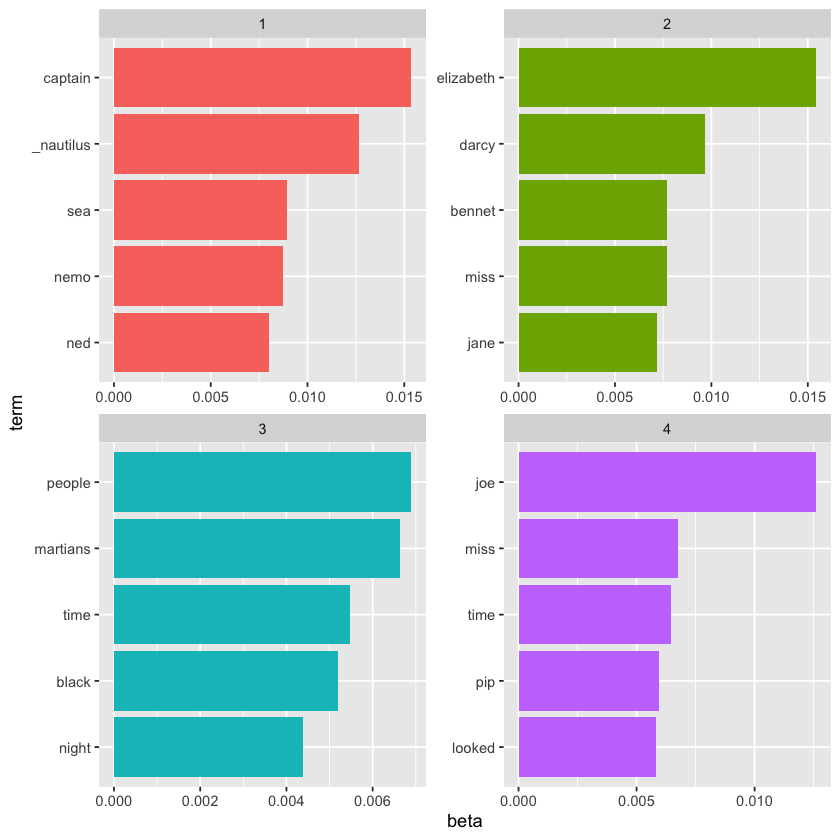

In [123]:
library(ggplot2)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()

These topics are pretty clearly associated with the four books! There’s no question that the topic of “captain”, “nautilus”, “sea”, and “nemo” belongs to Twenty Thousand Leagues Under the Sea, and that “jane”, “darcy”, and “elizabeth” belongs to Pride and Prejudice. We see “pip” and “joe” from Great Expectations and “martians”, “black”, and “night” from The War of the Worlds. We also notice that, in line with LDA being a “fuzzy clustering” method, there can be words in common between multiple topics, such as “miss” in topics 1 and 4, and “time” in topics 3 and 4.

#### Per-document classification

Each document in this analysis represented a single chapter. Thus, we may want to know which topics are associated with each document. Can we put the chapters back together in the correct books? We can find this by examining the per-document-per-topic probabilities, 
γ
 (“gamma”).

In [124]:
chapters_gamma <- tidy(chapters_lda, matrix = "gamma")
print(chapters_gamma)

# A tibble: 784 x 3
   document                 topic     gamma
   <chr>                    <int>     <dbl>
 1 Great Expectations_60        1 0.0000122
 2 Great Expectations_7         1 0.0000129
 3 Great Expectations_17        1 0.0000189
 4 Great Expectations_28        1 0.0000173
 5 Great Expectations_39        1 0.0000117
 6 Great Expectations_2         1 0.0000152
 7 Great Expectations_24        1 0.0000168
 8 Great Expectations_15        1 0.0000128
 9 Great Expectations_18        1 0.0000114
10 The War of the Worlds_16     1 0.0000100
# i 774 more rows


Each of these values is an estimated proportion of words from that document that are generated from that topic. For example, the model estimates that each word in the Great Expectations_57 document has only a 0% probability of coming from topic 1 (Pride and Prejudice).

Now that we have these topic probabilities, we can see how well our unsupervised learning did at distinguishing the four books. We’d expect that chapters within a book would be found to be mostly (or entirely), generated from the corresponding topic.

First we re-separate the document name into title and chapter, after which we can visualize the per-document-per-topic probability for each.

In [106]:
chapters_gamma <- chapters_gamma %>%
  separate(document, c("title", "chapter"), sep = "_", convert = TRUE)

print(chapters_gamma)

# A tibble: 664 x 4
   title              chapter topic     gamma
   <chr>                <int> <int>     <dbl>
 1 Great Expectations      57     1 0.0000129
 2 Great Expectations       7     1 0.0580   
 3 Great Expectations      17     1 0.0000201
 4 Great Expectations      27     1 0.0000183
 5 Great Expectations      38     1 0.0000124
 6 Great Expectations       2     1 0.0000161
 7 Great Expectations      23     1 0.0000178
 8 Great Expectations      15     1 0.0000136
 9 Great Expectations      18     1 0.0000121
10 Great Expectations       9     1 0.0000214
# i 654 more rows


# Look into fixing below

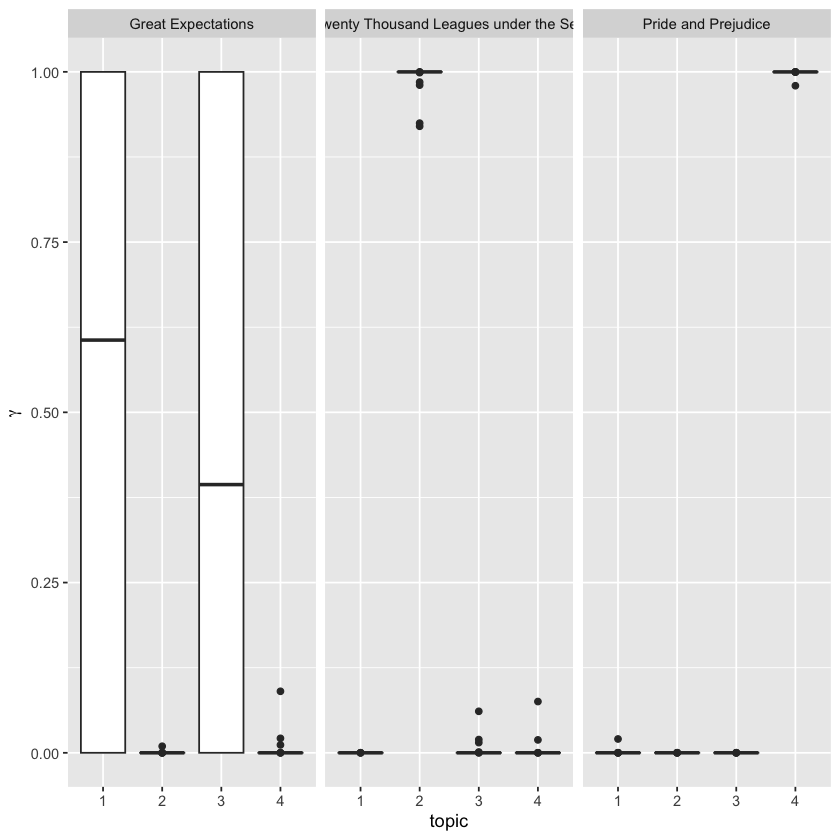

In [107]:
# reorder titles in order of topic 1, topic 2, etc before plotting
chapters_gamma %>%
  mutate(title = reorder(title, gamma * topic)) %>%
  ggplot(aes(factor(topic), gamma)) +
  geom_boxplot() +
  facet_wrap(~ title) +
  labs(x = "topic", y = expression(gamma))

We notice that almost all of the chapters from Pride and Prejudice, War of the Worlds, and Twenty Thousand Leagues Under the Sea were uniquely identified as a single topic each.

It does look like some chapters from Great Expectations (which should be topic 4) were somewhat associated with other topics. Are there any cases where the topic most associated with a chapter belonged to another book? First we’d find the topic that was most associated with each chapter using slice_max(), which is effectively the “classification” of that chapter.

In [108]:
chapter_classifications <- chapters_gamma %>%
  group_by(title, chapter) %>%
  slice_max(gamma) %>%
  ungroup()

print(chapter_classifications)

# A tibble: 166 x 4
   title              chapter topic gamma
   <chr>                <int> <int> <dbl>
 1 Great Expectations       1     3 1.00 
 2 Great Expectations       2     3 1.00 
 3 Great Expectations       3     3 1.00 
 4 Great Expectations       4     3 1.00 
 5 Great Expectations       5     3 1.00 
 6 Great Expectations       6     3 1.00 
 7 Great Expectations       7     3 0.942
 8 Great Expectations       8     1 1.00 
 9 Great Expectations       9     3 1.00 
10 Great Expectations      10     3 1.00 
# i 156 more rows


We can then compare each to the “consensus” topic for each book (the most common topic among its chapters), and see which were most often misidentified.

In [109]:
book_topics <- chapter_classifications %>%
  count(title, topic) %>%
  group_by(title) %>%
  slice_max(n, n = 1) %>% 
  ungroup() %>%
  transmute(consensus = title, topic)

chapter_classifications %>%
  inner_join(book_topics, by = "topic") %>%
  filter(title != consensus)


title,chapter,topic,gamma,consensus
<chr>,<int>,<int>,<dbl>,<chr>


We see that only two chapters from Great Expectations were misclassified, as LDA described one as coming from the “Pride and Prejudice” topic (topic 1) and one from The War of the Worlds (topic 3). That’s not bad for unsupervised clustering!

#### By Word Assignments: `augment`

One step of the LDA algorithm is assigning each word in each document to a topic. The more words in a document are assigned to that topic, generally, the more weight (`gamma`) will go on that document-topic classification.

We may want to take the original document-word pairs and find which words in each document were assigned to which topic. This is the job of the [`augment()`](https://generics.r-lib.org/reference/augment.html) function, which also originated in the broom package as a way of tidying model output. While [`tidy()`](https://generics.r-lib.org/reference/tidy.html) retrieves the statistical components of the model, [`augment()`](https://generics.r-lib.org/reference/augment.html) uses a model to add information to each observation in the original data.


In [110]:
assignments <- augment(chapters_lda, data = chapters_dtm)
print(assignments)

# A tibble: 90,959 x 4
   document              term  count .topic
   <chr>                 <chr> <dbl>  <dbl>
 1 Great Expectations_57 joe      88      3
 2 Great Expectations_7  joe      70      3
 3 Great Expectations_17 joe       5      3
 4 Great Expectations_27 joe      58      3
 5 Great Expectations_2  joe      56      3
 6 Great Expectations_23 joe       1      3
 7 Great Expectations_15 joe      50      3
 8 Great Expectations_18 joe      50      3
 9 Great Expectations_9  joe      44      3
10 Great Expectations_13 joe      40      3
# i 90,949 more rows


This returns a tidy data frame of book-term counts, but adds an extra column: `.topic`, with the topic each term was assigned to within each document. (Extra columns added by `augment` always start with `.`, to prevent overwriting existing columns). We can combine this `assignments` table with the consensus book titles to find which words were incorrectly classified.

In [111]:
assignments <- assignments %>%
  separate(document, c("title", "chapter"), 
           sep = "_", convert = TRUE) %>%
  inner_join(book_topics, by = c(".topic" = "topic"))

print(assignments)

# A tibble: 72,144 x 6
   title              chapter term    count .topic consensus         
   <chr>                <int> <chr>   <dbl>  <dbl> <chr>             
 1 Great Expectations      30 joe         2      1 Great Expectations
 2 Great Expectations       8 joe         2      1 Great Expectations
 3 Great Expectations      43 joe         2      1 Great Expectations
 4 Great Expectations      39 joe         2      1 Great Expectations
 5 Great Expectations      51 estella     1      1 Great Expectations
 6 Great Expectations      29 estella    24      1 Great Expectations
 7 Great Expectations      46 estella     1      1 Great Expectations
 8 Great Expectations      30 estella     3      1 Great Expectations
 9 Great Expectations      44 estella    26      1 Great Expectations
10 Great Expectations      32 estella     2      1 Great Expectations
# i 72,134 more rows


This combination of the true book (`title`) and the book assigned to it (`consensus`) is useful for further exploration. We can, for example, visualize a **confusion matrix**, showing how often words from one book were assigned to another, using dplyr’s [`count()`](https://dplyr.tidyverse.org/reference/count.html) and ggplot2’s `geom_tile`.

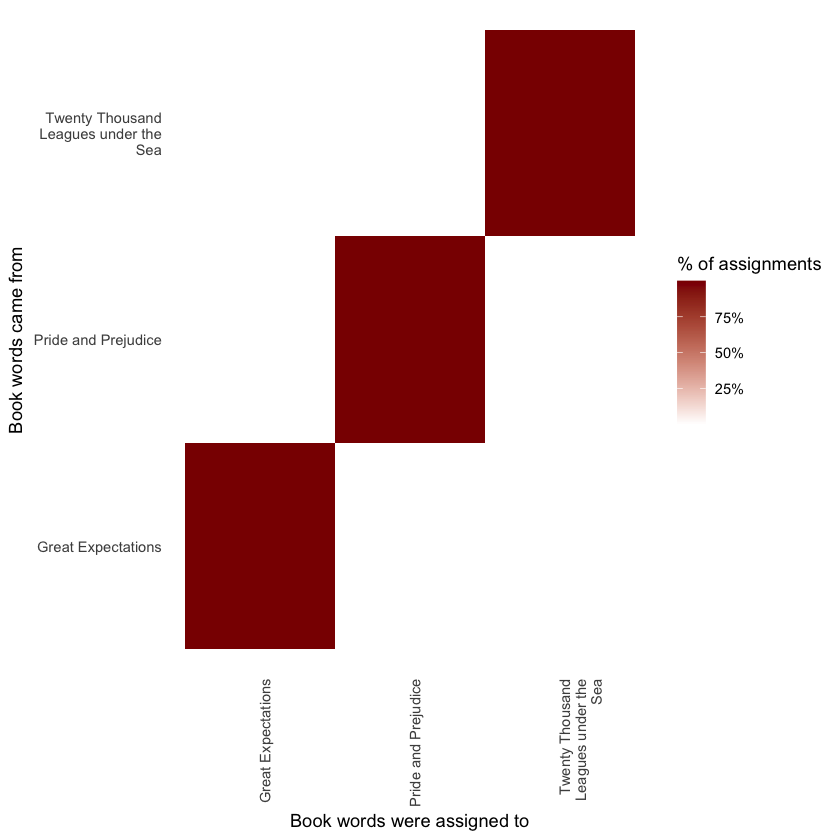

In [112]:
library(scales)

assignments %>%
  count(title, consensus, wt = count) %>%
  mutate(across(c(title, consensus), ~str_wrap(., 20))) %>%
  group_by(title) %>%
  mutate(percent = n / sum(n)) %>%
  ggplot(aes(consensus, title, fill = percent)) +
  geom_tile() +
  scale_fill_gradient2(high = "darkred", label = percent_format()) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid = element_blank()) +
  labs(x = "Book words were assigned to",
       y = "Book words came from",
       fill = "% of assignments")